# PROYECTO - 3 FILTROS - INFORME

### David Alejandro Henao - Maria Camila Bravo

#### Objetivo: Implementar un flujo de procesamiento que incluya filtrado de las señales y extracción de características espectrales
Los numerales del informen se desarrollaran a lo largo de la Guia


## 1. ENTREGABLE

1. Consultar y explicar los dos métodos de reducción de ruido usados en el artículo: Robust LOESS y Non Local Means (10%), mostrar cómo se podrían implementar en Python (5%)

**Robust LOESS:**

Este método es una variante robusta del ajuste LOESS, que elimina el "baseline wandering" o deriva de línea base en las señales de ECG. El ajuste LOESS (Locally Estimated Scatterplot Smoothing) es una técnica de suavizado que aplica regresión local para adaptar una curva en segmentos pequeños de datos. La versión robusta es particularmente útil para evitar que datos atípicos influyan en el ajuste, lo que ayuda a mantener la señal ECG en su forma original sin que las desviaciones lentas o las variaciones lentas interfieran en la interpretación de la señal​ [1].

En Python se podría realizar ajustes lineales locales ponderados. se puede usar la biblioteca statsmodels de Python para aplicar LOWESS. El paquete incluye una función lowess y se puede controlar el grado de suavizado ajustando el parámetro frac y aplicar un ajuste robusto para reducir la influencia de valores atípicos en los datos. Un ejemplo básico con statsmodels genera una curva suavizada a partir de datos con ruido, y se puede ver cómo el suavizado ayuda a representar la tendencia principal de los datos de forma clara [2].

**Non-Local Means (NLM):**

El algoritmo NLM se usa para eliminar el ruido residual restante después de aplicar el filtro LOESS. Este método es especialmente útil para preservar las estructuras repetitivas de las señales. NLM promedia puntos de datos cercanos que tienen patrones similares, lo cual ayuda a reducir el ruido sin afectar la estructura de la señal. Para cada punto, el algoritmo evalúa su similitud con otros puntos en un rango predefinido y luego calcula un promedio ponderado que mantiene las características de la señal mientras elimina ruido aleatorio[1].

Para implementar NLM, en Python la biblioteca scikit-image tiene una función denoise_nl_means la cual se puede usar para la reducción de ruido en imágenes y puede adaptarse a series temporales como ECG. El método compara cada punto con otros en un rango definido y calcula un promedio ponderado según la similitud de patrones, lo que ayuda a eliminar ruido sin distorsionar los detalles de la señal[3].


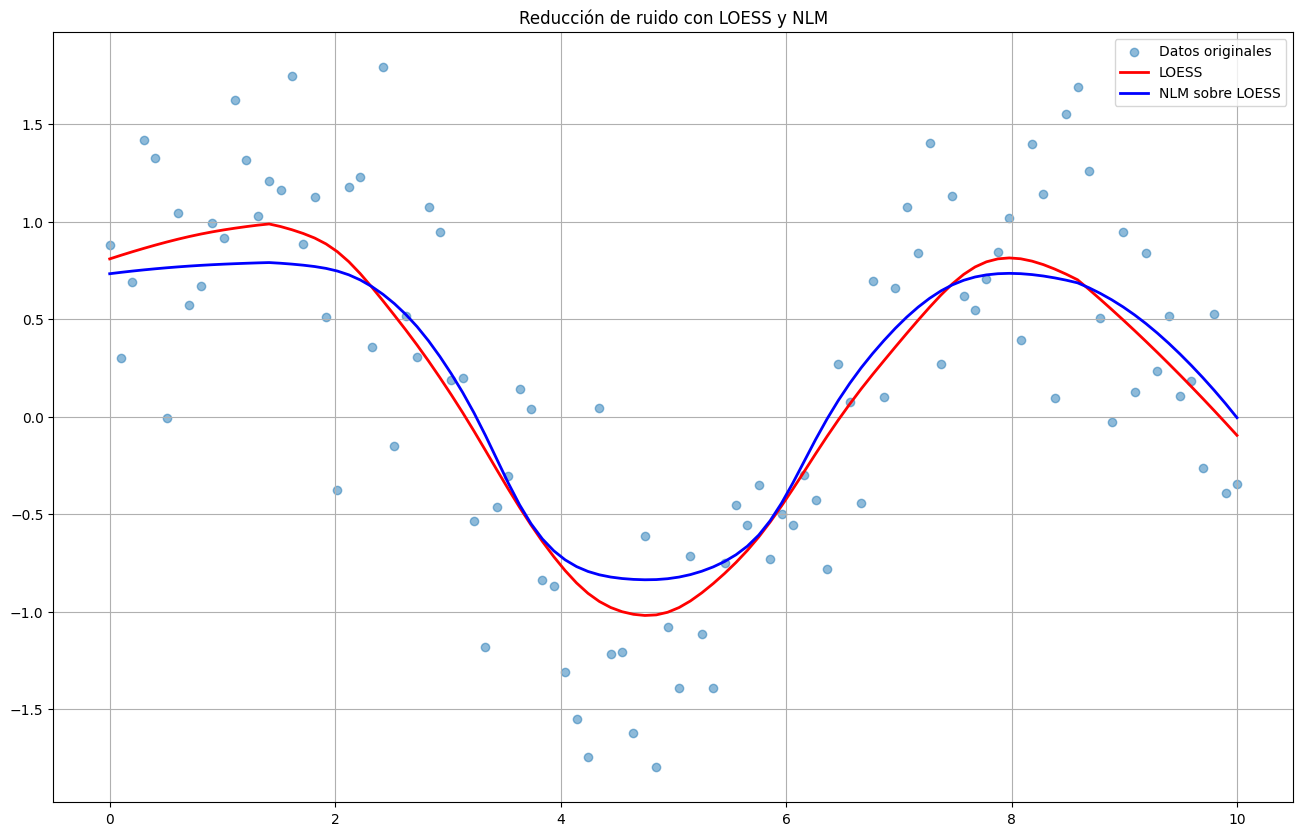

In [165]:
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Aqui generamos datos aleatorios
np.random.seed(0)
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(scale=0.5, size=x.shape)

# Aplicar LOESS
lowess = lowess(y, x, frac=0.3,it = 3)# el valor frac va a determinar que tan suave sera la curva, un valor bajo va a generar sobreajuste, y valores altos vana generar más suavizao.
# el valor de it va a determianr que tan robusto es o no el filtrado, a mayor it mas robusto pues habrán más iteraciones.
y_lowess = lowess[:, 1]

# Función para aplicar Non-Local Means
def non_local_means(data, h):
    n = len(data)
    denoised = np.zeros_like(data)
    
    for i in range(n):
        # Calcular las distancias desde el punto i a todos los demás puntos
        distances = np.abs(data - data[i])
        weights = np.exp(-distances**2 / (h**2))
        denoised[i] = np.sum(weights * data) / np.sum(weights)
    
    return denoised

# Aplicar Non-Local Means a la salida de LOESS
h = 0.5  # Parámetro de suavizado
y_nlm = non_local_means(y_lowess, h)

# Graficar resultados
plt.figure(figsize=(16, 10))
plt.scatter(x, y, label='Datos originales', alpha=0.5)
plt.plot(x, y_lowess, color='red', label='LOESS', linewidth=2)
plt.plot(x, y_nlm, color='blue', label='NLM sobre LOESS', linewidth=2)
plt.legend()
plt.grid(True)
plt.title('Reducción de ruido con LOESS y NLM')
plt.show()

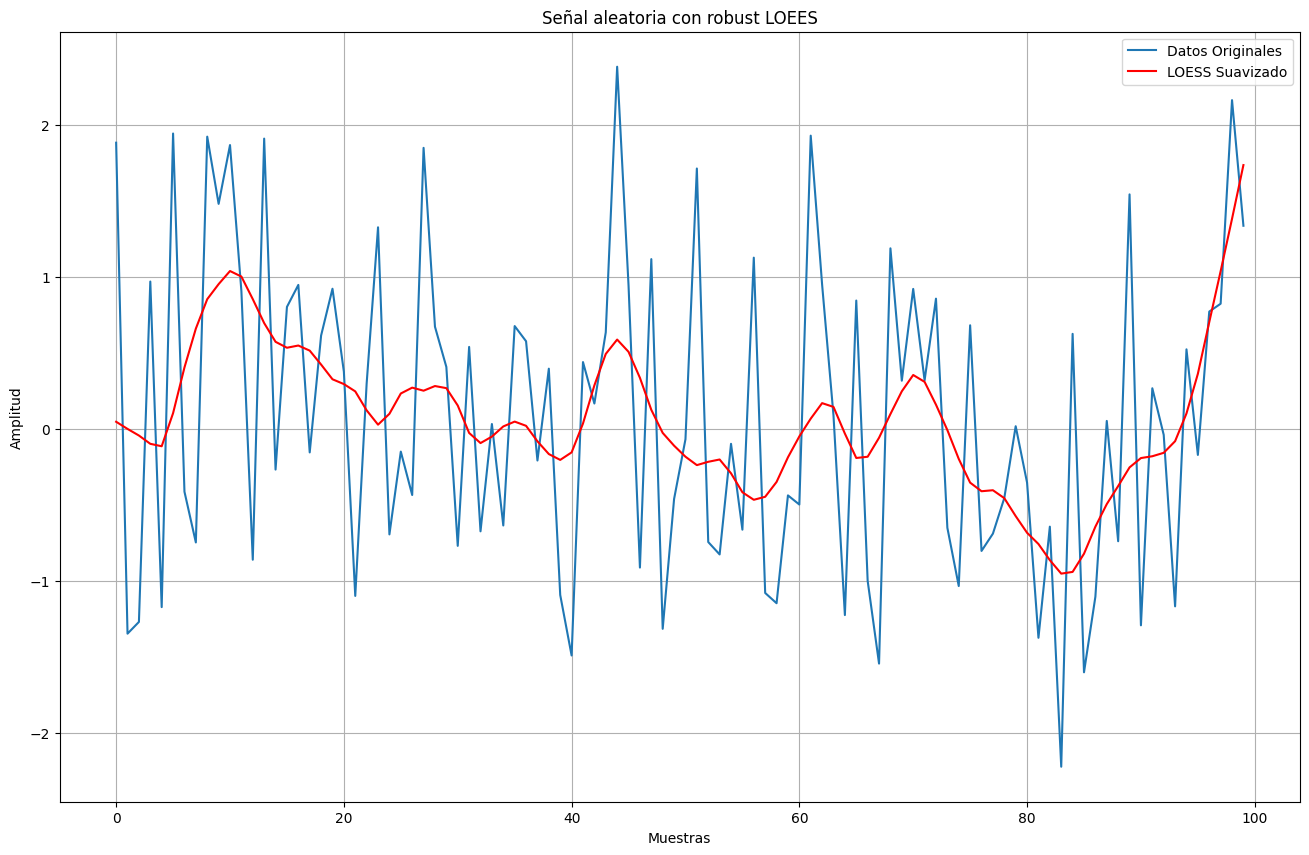

In [166]:
# Con una señal aleatoria continua 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

data = np.random.randn(100)  # Datos de ejemplo
smoothed = lowess(data, np.arange(len(data)), frac=0.1, it=1) 
plt.figure(figsize=(16, 10))
plt.plot(data, label='Datos Originales')
plt.plot(smoothed[:, 0], smoothed[:, 1], label='LOESS Suavizado', color='r')
plt.legend()
plt.xlabel('Muestras')
plt.title('Señal aleatoria con robust LOEES')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

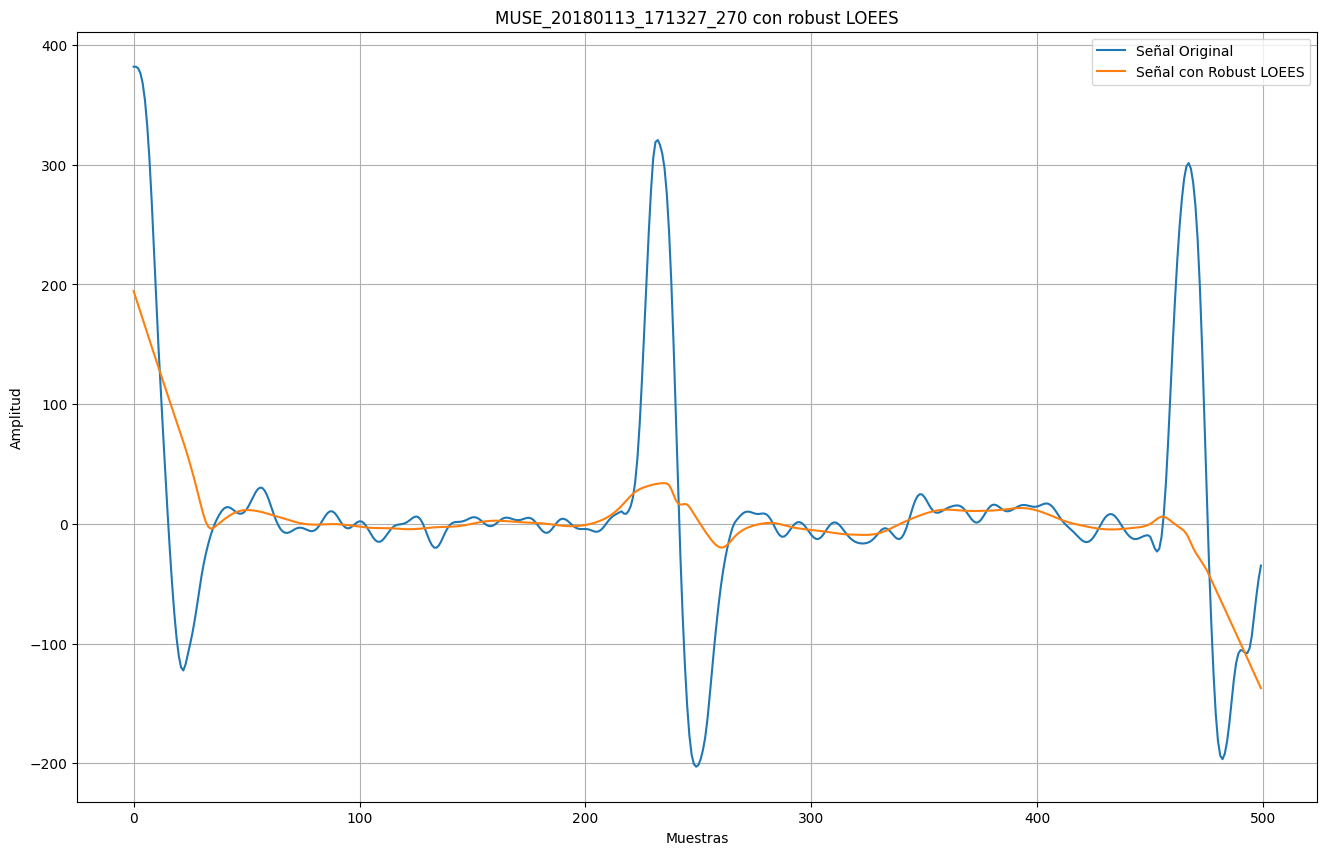

In [167]:
# Ejemplo de uso con una señal de la base de datos:
#csv = r'c:\\Users\\User\\OneDrive - Universidad de Antioquia\\David\\2024 - 2\\Bioseñales\\lab\\Proyecto3\\ECGDataDenoised\MUSE_20180113_171327_27000.csv'
csv = '/Users/mcamilabravo/Documents/Universidad 2024:2/Biosenales/Proyecto 2/ECGDataDenoised/MUSE_20180113_171327_27000.csv'
df = pd.read_csv(csv, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
x0 = df['II'].values

smoothed = lowess(x0[:500], np.arange(len(x0[:500])), frac=0.1, it=3) #con 3 iteraciones para que sea 'robusto'

# Visualizar la señal original, la tendencia y la señal des-trendida
plt.figure(figsize=(16, 10))
plt.plot(x0[:500], label='Señal Original')
plt.plot(smoothed[:, 1], label='Señal con Robust LOEES')
plt.legend()
plt.title('MUSE_20180113_171327_270 con robust LOEES')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

#### Eficacia de los Métodos de Filtrado:
La combinación de los métodos Robust LOESS y Non-Local Means (NLM) demostró una notable efectividad en la reducción de ruido en señales ECG. Ambos métodos tienen enfoques distintos y complementarios: el filtrado Robust LOESS es particularmente útil para eliminar el ruido de baja frecuencia y tendencias de fondo, ya que suaviza la señal localmente mientras mantiene la estructura esencial de los datos. Por otro lado, el método Non-Local Means se enfoca en reducir el ruido de alta frecuencia y preservar detalles finos al realizar una comparación entre segmentos similares de la señal, lo cual es crucial en señales ECG para conservar características importantes como picos y ondas.

La combinación de estos dos enfoques permite una depuración más robusta de la señal: el método LOESS asegura que las variaciones a largo plazo y el ruido de baja frecuencia se reduzcan, mientras que el método NLM mantiene la integridad de los elementos detallados y específicos. Como resultado, la señal ECG final presenta un balance óptimo entre la eliminación de ruido y la preservación de los componentes clínicamente significativos, lo cual es vital para el análisis médico. Esta sinergia entre ambos métodos destaca su utilidad para aplicaciones que requieren alta precisión en la interpretación de datos bioseñales.


## 2.EXTRACIÓN DE REGISTROS 

De la base de datos extraer los registros que correspondan a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). Esta información está en el archivo Diagnostics.xlsx

PUNTOS 2 Y 3 JUSTIFICADOS A LO LARGO DE LA GUIA

In [168]:
#ruta = "c:\\Users\\User\\OneDrive - Universidad de Antioquia\\David\\2024 - 2\\Bioseñales\\lab\\Proyecto3\\Diagnostics.xlsx"
ruta = "/Users/mcamilabravo/Documents/Universidad 2024:2/Biosenales/Proyecto 2/Diagnostics.xlsx"

dataframe = pd.read_excel(ruta)
df_filtrado= dataframe[(dataframe['Rhythm'] == 'SB') | (dataframe['Rhythm'] == 'AFIB')]
df_filtrado = df_filtrado.reset_index(drop=True)
df_filtrado = df_filtrado[['FileName','Rhythm']]
df_filtrado.head()

,FileName,Rhythm
0,MUSE_20180113_171327_27000,AFIB
1,MUSE_20180112_073319_29000,SB
2,MUSE_20180113_121940_44000,SB
3,MUSE_20180112_120347_79000,SB
4,MUSE_20180114_075026_69000,AFIB


In [169]:
# Función para la extracción de los datos
def obtener_nombres_archivos_por_ritmo(ruta_excel, ritmos_AFIB=['AFIB'], ritmos_SB=['SB']):
    dataframe = pd.read_excel(ruta_excel)
    # Filtrar por los ritmos deseados y extraer los nombres de archivo
    nombres_AFIB = dataframe[dataframe['Rhythm'].isin(ritmos_AFIB)]['FileName'].tolist()
    nombres_SB = dataframe[dataframe['Rhythm'].isin(ritmos_SB)]['FileName'].tolist()
    return nombres_AFIB, nombres_SB

def leer_archivos_ecg(nombres_AFIB, nombres_SB, ruta_carpeta):
    datos_AFIB = {}
    datos_SB = {}
    
    for nombre_archivo in nombres_AFIB + nombres_SB:
        ruta_archivo = os.path.join(ruta_carpeta, f"{nombre_archivo}.csv")
        
        # Verificar si el archivo existe
        if os.path.exists(ruta_archivo):
            df = pd.read_csv(ruta_archivo, delimiter=',', skiprows=1, names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
            # Guardar los datos de la columna 'II'
            if nombre_archivo in nombres_AFIB:
                datos_AFIB[nombre_archivo] = df['II'].values
            else:
                datos_SB[nombre_archivo] = df['II'].values
        else:
            print(f"Archivo {ruta_archivo} no encontrado.")
    
    return datos_AFIB, datos_SB

In [170]:
# Ruta al archivo Excel y a la carpeta de archivos .csv
#ruta_excel = r'c:\\Users\\User\\OneDrive - Universidad de Antioquia\\David\\2024 - 2\\Bioseñales\\lab\\Proyecto3\\Diagnostics.xlsx'
#ruta_carpeta_csv =  r'c:\\Users\\User\\OneDrive - Universidad de Antioquia\\David\\2024 - 2\\Bioseñales\\lab\\Proyecto3\\ECGDataDenoised'
ruta_excel = "/Users/mcamilabravo/Documents/Universidad 2024:2/Biosenales/Proyecto 2/Diagnostics.xlsx"
ruta_carpeta_csv = "/Users/mcamilabravo/Documents/Universidad 2024:2/Biosenales/Proyecto 2/ECGDataDenoised"


# Extraer los nombres de archivos que nos interesan
nombres_AFIB, nombres_SB = obtener_nombres_archivos_por_ritmo(ruta_excel)

# Leer los datos de los archivos ECG
valores_AFIB, valores_SB = leer_archivos_ecg(nombres_AFIB, nombres_SB, ruta_carpeta_csv)

# 3.CONSULTA

#### TIPOS DE SEÑALES WAVELET
Para el análisis de señales ECG las cuales incluyen componentes de frecuencia diferentes y ubicaciones temporales distintas. Es común usar las siguientes familias de wavelet: Daubechies, Symlet, coiflet ,  Meyer y Mexican[4]. 
### Symlet Wavelet
Las wavelets Symlet son wavelets casi simétricas y tienen propiedades similares a la familia db, quienes fueron diseñadas para mejorar la simetría y la regularidad, lo que las hace más adecuadas para representar señales con características específicas en el dominio de la frecuencia y el tiempo[4]. Se recomiendan en aplicaciones donde se requiere alta precisión en la reconstrucción de señales y reducción de distorsión.  Ejemplo en Análisis de señales ECG: Mejoran la precisión al filtrar ruido sin distorsionar los detalles críticos de la señal cardíaca.
### Coiflet (coif) Wavelet :
Estas wavelets tienen soporte compacto lo que se definen en un intervalo finito, que mejora su eficiencia en aplicaciones computacionales[5]. Están diseñadas con un número específico de momentos de desvanecimiento (propiedades que ayudan a eliminar componentes de baja frecuencia). En las Coiflets, la función wavelet tiene 2N momentos nulos y la función de escalamiento tiene 2N - 1 momentos nulos, lo cual permite una representación precisa en el análisis y reconstrucción de señales. Esta wavelet es ideal para la compresión de señales y procesamiento de imágenes.
### Wavelet Meyer:
Es una wavelet ortogonal con una forma suave e infinitamente diferenciable, Meyer calcula los valores en una cuadrícula regular [5]. Lo que la hace adecuada para capturar variaciones sutiles en señales como el ECG. Debido a su soporte no compacto y su transición gradual en el dominio de frecuencia, puede analizar señales de ECG sin introducir efectos bruscos, lo cual es útil para distinguir componentes de baja frecuencia, como los latidos cardíacos y sus patrones. 
### Mexican  Wavelet:
La wavelet Mexican Hat se obtiene de la segunda derivada de la función Gaussiana y es útil para analizar señales como el ECG debido a su estructura en forma de onda. Al aplicarse un factor de escala y un factor de traslación, la wavelet puede adaptarse a diferentes frecuencias y posiciones temporales, lo que la hace eficaz para detectar detalles tanto en el tiempo como en la frecuencia de la señal[6].


CONCLUSIÓN
 En el código entregado en el curso se utiliza la wavelet db6 (Daubechies 6), la cual es muy común en el análisis de las señales ECG. Esta wavelet tiene 6 coeficientes y tiene la capacidad de filtrar ruidos mientras mantiene detalles importantes de la señal. En el caso de señales ECG, Para la bradicardia sinusal (SB) y la fibrilación auricular (AFIB), el uso de Daubechies (db6) mantiene las  características principales, detecta las señales rápidas, reduce el ruido y descompone la señal. Como en el complejo QRS, sin distorsionar las ondas P y T. 
 En el caso de Fibrilación las señales tienen patrones irregulares debido a las arritmias, mientras que en la bradicardia presentan señales de frecuencia más lentas por lo tanto con base en la consulta se podria probar con wavelet sym o coif la cual podría realizar detección de patrones más complejos y detención de las variaciones en las ondas P y T, sin perder detalles importantes en señales con baja frecuencia y alta variabilidad. En clase se recomendo no pasar de nivel superior a 8. Por lo tanto se eligio Symlet Wavelet en nivel 8. 

In [171]:
# Código entregado en el curso 
def filtro_denoise_wavelet(entrada, wavelet='db6', nivel=8):
    # Paso 1: Descomposición en coeficientes wavelet
    coeficientes = pywt.wavedec(entrada, wavelet, level=nivel)
    detalles = coeficientes[1:]  # Ignorar la aproximación inicial en el nivel más alto

    # Paso 2: Cálculo de la desviación estándar del ruido (basado en wnoisest)
    desviaciones_std = [np.median(np.abs(detalle)) / 0.6745 for detalle in detalles]

    # Paso 3: Cálculo del umbral (basado en threshold)
    num_muestras = sum([detalle.size for detalle in detalles])
    umbral = np.sqrt(2 * np.log(num_muestras))

    # Paso 4: Aplicar el umbral a los coeficientes detallados (basado en wthresh)
    detalles_filtrados = []
    for i, detalle in enumerate(detalles):
        umbralizado = np.multiply(detalle, np.abs(detalle) > (umbral * desviaciones_std[i]))
        detalles_filtrados.append(umbralizado)

    # Reconstruir la señal utilizando los coeficientes de aproximación original y los detalles filtrados
    coeficientes_filtrados = [coeficientes[0]] + detalles_filtrados
    señal_filtrada = pywt.waverec(coeficientes_filtrados, wavelet)
    señal_filtrada = señal_filtrada[:entrada.shape[0]]  # Asegurar que la longitud coincide

    # Graficar señal original
    plt.figure(figsize=(12, 6))
    plt.plot(entrada, label='Señal Original')
    plt.title("Señal Original")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.show()

    # Graficar señal filtrada (reconstruida)
    plt.figure(figsize=(12, 6))
    plt.plot(señal_filtrada, label='Señal Filtrada (Reconstruida)', color='orange')
    plt.title("Señal Filtrada")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.show()

    return señal_filtrada, umbral, desviaciones_std

#### EJEMPLO Symlet (sym)

Se requiere instalar  PyWavelets ,

In [172]:
import pywt
import numpy as np

def SYMLET_wavelet(señal, wavelet='sym8', nivel=8):
    # Descomposición en wavelet usando Symlet (sym8) con el nivel definido
    coef = pywt.wavedec(señal, wavelet, level=nivel)
    detalles = coef[1:]

    # Cálculo de las desviaciones estándar de cada coeficiente de detalle
    std = [np.median(np.abs(d)) / 0.6745 for d in detalles]
    muestras = sum([d.size for d in detalles])
    
    # Cálculo del umbral
    umbral = np.sqrt(2 * np.log(muestras))

    # Aplicación del umbral a los coeficientes de detalle
    detalles_umbralizados = []
    for i, d in enumerate(detalles):
        umbralizado = np.multiply(d, np.abs(d) > (umbral * std[i]))
        detalles_umbralizados.append(umbralizado)

    # Reconstrucción de la señal utilizando los coeficientes filtrados
    coef_filtrados = [coef[0]] + detalles_umbralizados
    señal_filtrada = pywt.waverec(coef_filtrados, wavelet)
    
    return señal_filtrada


## 4. FLUJO DE PROCESAMIENTOS

Escoger 10 señales al azar y aplicar un flujo de procesamiento que conste de:

In [173]:
import random # para seleccionar de forma aleatoria las 10 señales

def seleccionar_señales_aleatorias(valores_SB, valores_AFIB, num_selecciones=5):
    # Asegurarse de que hay suficientes señales para seleccionar
    if len(valores_SB) < num_selecciones or len(valores_AFIB) < num_selecciones:
        raise ValueError("No hay suficientes señales en uno de los diccionarios para seleccionar.")

    # Seleccionar claves aleatorias
    claves_SB = random.sample(list(valores_SB.keys()), num_selecciones)
    claves_AFIB = random.sample(list(valores_AFIB.keys()), num_selecciones)

    # Obtener las señales correspondientes
    señales_SB = {clave: valores_SB[clave] for clave in claves_SB}
    señales_AFIB = {clave: valores_AFIB[clave] for clave in claves_AFIB}

    return señales_SB, señales_AFIB

# Llamar a la función
señales_SB_aleatorias, señales_AFIB_aleatorias = seleccionar_señales_aleatorias(valores_SB, valores_AFIB)

# Imprimir las señales seleccionadas
print("Señales SB seleccionadas:", señales_SB_aleatorias)
print("Señales AFIB seleccionadas:", señales_AFIB_aleatorias)

Señales SB seleccionadas: {'MUSE_20180116_170540_50000': array([ 32.441,  33.649,  35.786, ..., -38.323, -53.314, -69.443]), 'MUSE_20180113_185106_24000': array([-29.668, -19.091,   9.634, ..., -58.434, -57.309, -56.36 ]), 'MUSE_20180116_173459_00000': array([-59.465 , -58.025 , -57.483 , ...,  -8.7827, -12.274 , -16.209 ]), 'MUSE_20180116_132129_83000': array([ -5.8361,  -9.6954, -10.733 , ..., -15.488 , -22.859 , -31.514 ]), 'MUSE_20180118_121851_90000': array([ 5.6519,  8.2558,  9.261 , ..., -5.6754, -7.4462, -9.0836])}
Señales AFIB seleccionadas: {'MUSE_20180118_172704_16000': array([-11.306, -12.   , -13.382, ...,  22.287,  20.786,  19.484]), 'MUSE_20180116_170910_87000': array([ -37.777,  -95.882, -152.98 , ...,   -8.286,  -15.195,  -23.602]), 'MUSE_20180116_170143_82000': array([-48.387 , -40.982 , -37.314 , ...,   7.4286,  -4.5223, -19.625 ]), 'MUSE_20180111_160117_84000': array([-18.98 , -17.329, -15.207, ..., -18.853, -17.543, -15.139]), 'MUSE_20180114_114650_75000': array([ 

### FUJO 1 

1. Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR
2. Filtro wavelet modificado del punto 3
3. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pywt


#FILTRO PASA-ALTAS 
def filtro_pasa_altos(señal, fc=0.5, fs=500, orden=2):
    # Calcular la frecuencia de Nyquist
    nyquist = 0.5 * fs
    corte_normalizado = fc/ nyquist  # Normalizar la frecuencia de corte
    b, a = signal.butter(orden, corte_normalizado, btype='high', analog=False)  # Filtro IIR
    señal_filtrada = signal.filtfilt(b, a, señal)  # Aplicar filtro de manera eficiente
    return señal_filtrada

#FILTRO PASA-BAJAS 50 HZ
def filtro_pasa_bajas (señal, fc=50, fs=500, orden=50):
    nyquist = 0.5 * fs
    corte_normalizado = fc / nyquist  # Normalizar la frecuencia de corte
    b = signal.firwin(orden, corte_normalizado)  # Filtro FIR
    señal_filtrada = signal.filtfilt(b, [1.0], señal)  # Aplicar filtro de manera eficiente
    return señal_filtrada



#### JUSTIFICACIÓN: 

fs = 500 porque es la frecuencia a la que fueron muestreadas las señales EKG  de la basa de datos.
La frecuencia de corte de 0.5 suponemos que se usa para eliminar componentes de muy baja frecuencia (como el movimiento de la línea base). Los filtros IIR suelen ser elegidos para este tipo de filtro debido a que logran una transición de frecuencia rápida con un orden más bajo en comparación con los FIR. Generalmente, un orden bajo (por ejemplo, entre 2 y 4) es suficiente para eliminar la línea base sin distorsionar demasiado la señal ECG.

Por otro lado para el, pasa bajas, un filtro FIR puede ser preferido debido a que permite diseñar filtros con respuesta de fase lineal, lo cual evita distorsiones en la forma de onda, y usamos un orden mucho mayor para tener un buen rechazo en la banda de paso y tener mejor rendimiento.

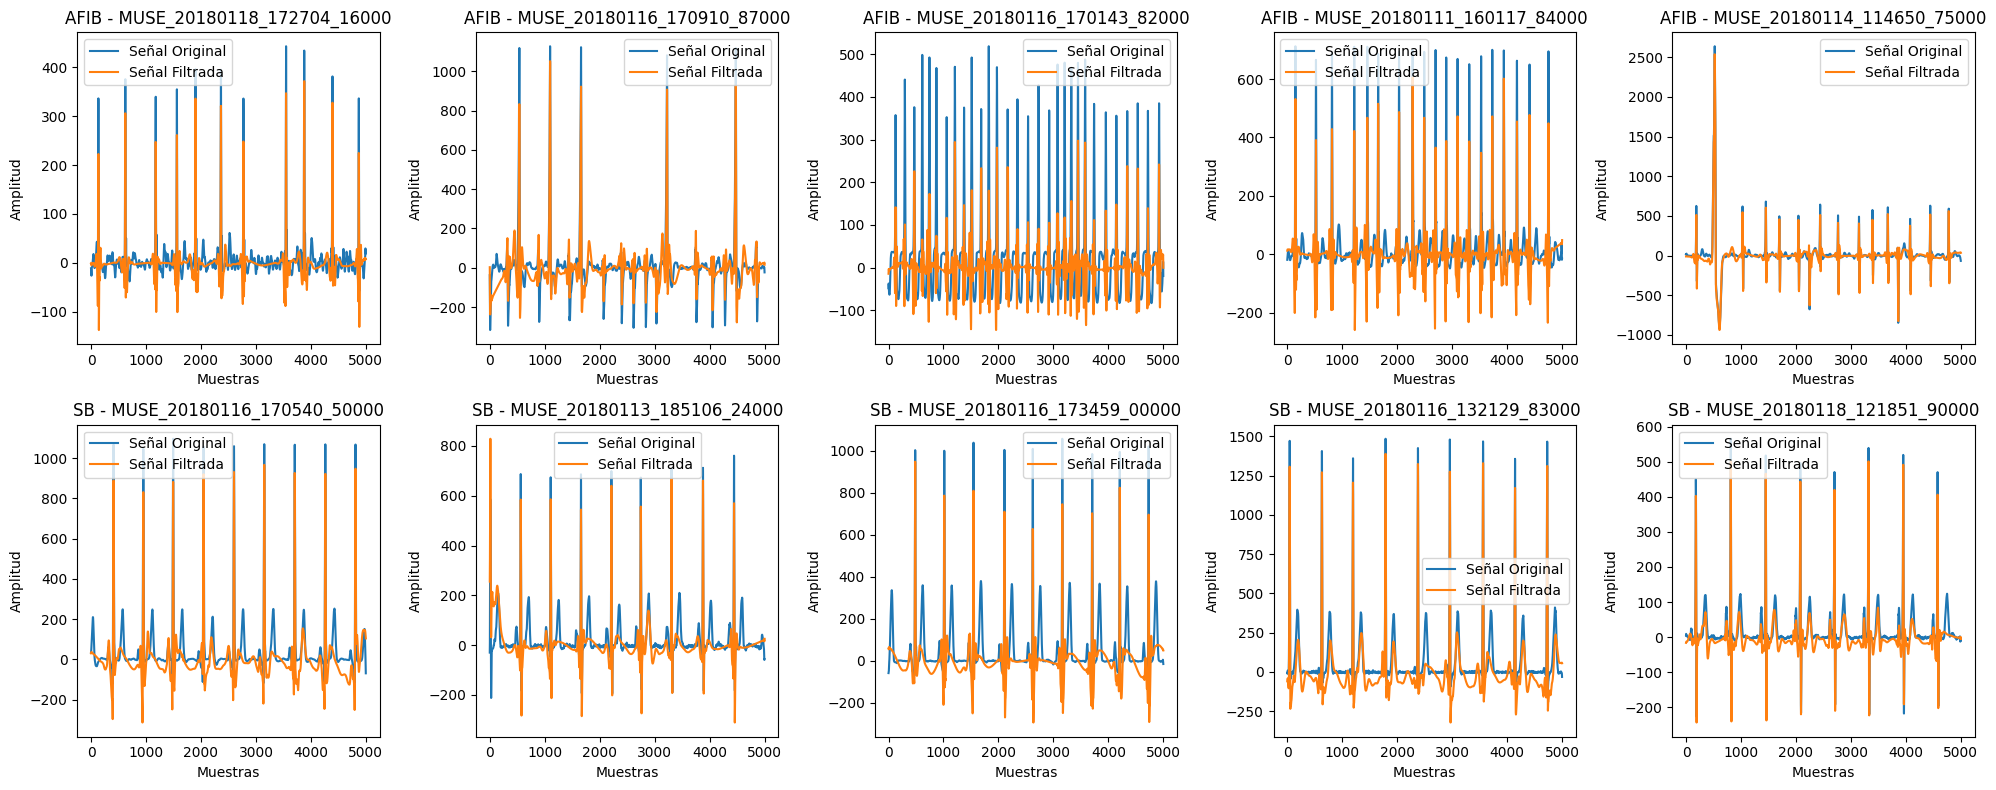

In [201]:
import matplotlib.pyplot as plt

# Función de flujo simplificada para graficar en un subplot
def flujo1(señales, tipo_señal, ax):
    for i, (nombre_señal, señal) in enumerate(señales.items()):
        # Filtro pasa-altas
        señal_filtrada_hp = filtro_pasa_altos(señal)
        
        # Aplicar la umbralización wavelet (SYMLET)
        señal_filtrada_wavelet = SYMLET_wavelet(señal_filtrada_hp, wavelet='sym8', nivel=8)
        
        # Filtro pasa-bajos
        señal_filtrada_final = filtro_pasa_bajas(señal_filtrada_wavelet)
        
        # Mostrar la señal original y filtrada en el subplot correspondiente
        ax[i].plot(señal, label='Señal Original')
        ax[i].plot(señal_filtrada_final, label='Señal Filtrada')
        ax[i].set_title(f"{tipo_señal} - {nombre_señal}")
        ax[i].set_xlabel("Muestras")
        ax[i].set_ylabel("Amplitud")
        ax[i].legend()

# Función optimizada para procesar señales de AFIB y SB en subplots
def procesar_todas_las_señales(valores_AFIB, valores_SB):
    # Selecciona las primeras 5 señales de cada tipo para graficarlas (10 subplots en total)
    señales_AFIB_seleccionadas = dict(list(valores_AFIB.items())[:5])
    señales_SB_seleccionadas = dict(list(valores_SB.items())[:5])
    
    # Crear figura y subplots organizados en una cuadrícula de 2x5
    fig, ax = plt.subplots(2, 5, figsize=(20, 8))
    ax = ax.flatten()  # Aplanar el arreglo de subplots para un fácil acceso
    
    # Procesar y graficar las señales
    flujo1(señales_AFIB_seleccionadas, 'AFIB', ax[:5])  # Primeras 5 subplots para AFIB
    flujo1(señales_SB_seleccionadas, 'SB', ax[5:])      # Últimas 5 subplots para SB
    
    plt.tight_layout()
    plt.show()

# Llamada a la función para procesar y graficar las señales en subplots
procesar_todas_las_señales(señales_AFIB_aleatorias, señales_SB_aleatorias)


### FUJO 2

1. Detrend
2. Filtro wavelet modificado del punto 3
3. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

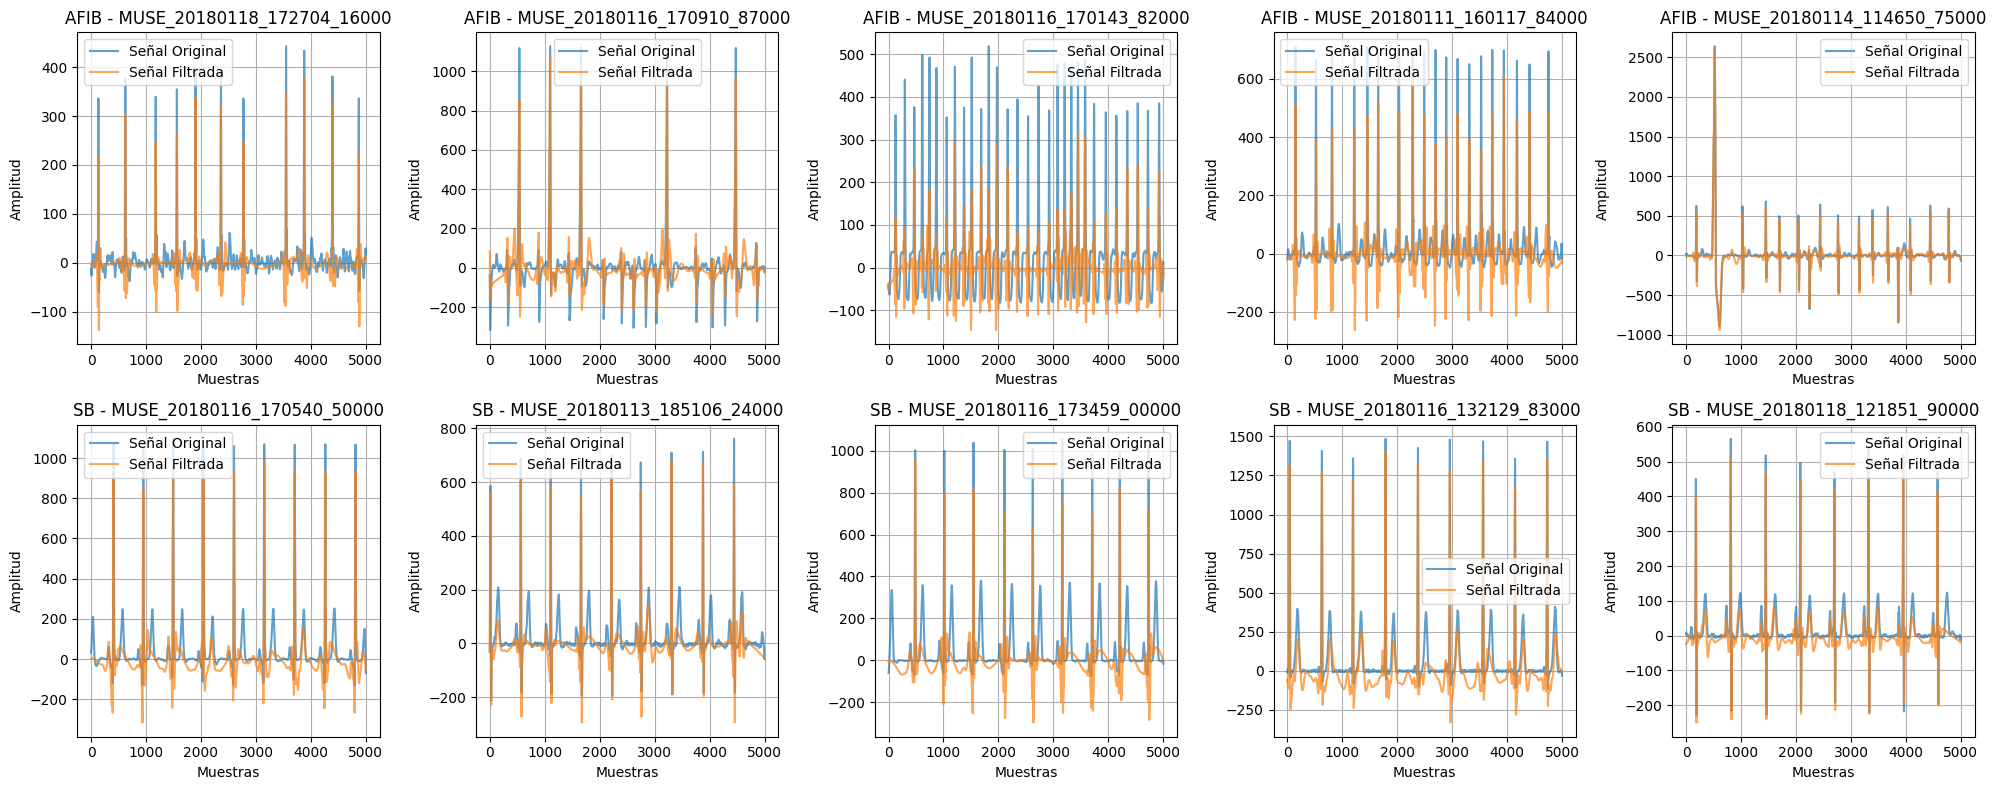

In [233]:
# Función para eliminar la tendencia lineal de la señal
def detrend_signal(señal):
    return signal.detrend(señal)  # Elimina la tendencia lineal de la señal

# Función para el flujo de procesamiento con detrend, wavelet y filtro pasa-bajos
def flujo_2(señales, tipo_señal, ax, fs=500):
    for i, (nombre_señal, señal) in enumerate(señales.items()):
        # Detrend (eliminar la tendencia lineal de la señal)
        señal_detrendida = detrend_signal(señal)
        
        # Filtro wavelet modificado (SYMLET)
        señal_filtrada_wavelet = SYMLET_wavelet(señal_detrendida, wavelet='sym8', nivel=8)
        
        # Filtro pasa-bajos 50 Hz
        señal_filtrada_final = filtro_pasa_bajos(señal_filtrada_wavelet, corte=50, fs=fs, orden=40)
        
        # Mostrar la señal original y filtrada en el subplot correspondiente
        ax[i].plot(señal, label='Señal Original', alpha=0.7)
        ax[i].plot(señal_filtrada_final, label='Señal Filtrada', alpha=0.7)
        ax[i].set_title(f"{tipo_señal} - {nombre_señal}")
        ax[i].set_xlabel("Muestras")
        ax[i].set_ylabel("Amplitud")
        ax[i].legend()
        ax[i].grid(True)

# Función optimizada para procesar y graficar señales de AFIB y SB en subplots
def procesar_todas_las_señales_flujo_2(valores_AFIB, valores_SB, fs=500):
    # Seleccionar las primeras 5 señales de cada tipo para graficarlas (10 subplots en total)
    señales_AFIB_seleccionadas = dict(list(valores_AFIB.items())[:5])
    señales_SB_seleccionadas = dict(list(valores_SB.items())[:5])
    
    # Crear figura y subplots organizados en una cuadrícula de 2x5
    fig, ax = plt.subplots(2, 5, figsize=(20, 8))
    ax = ax.flatten()  # Aplanar el arreglo de subplots para un fácil acceso
    
    # Procesar y graficar las señales
    flujo_2(señales_AFIB_seleccionadas, 'AFIB', ax[:5], fs)  # Primeras 5 subplots para AFIB
    flujo_2(señales_SB_seleccionadas, 'SB', ax[5:], fs)      # Últimas 5 subplots para SB
    
    plt.tight_layout()
    plt.show()

# Llamada a la función para procesar y graficar las señales en subplots con flujo 2
procesar_todas_las_señales_flujo_2(señales_AFIB_aleatorias, señales_SB_aleatorias, fs=500)


### FUJO 3

1. Filtro pasa-altas usando filtro IIR a 0.5 Hz
2. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

Para el flujo 3 se aplican los mismo filtros pasa altas IIR y pasa bajas IIR del flujo 1

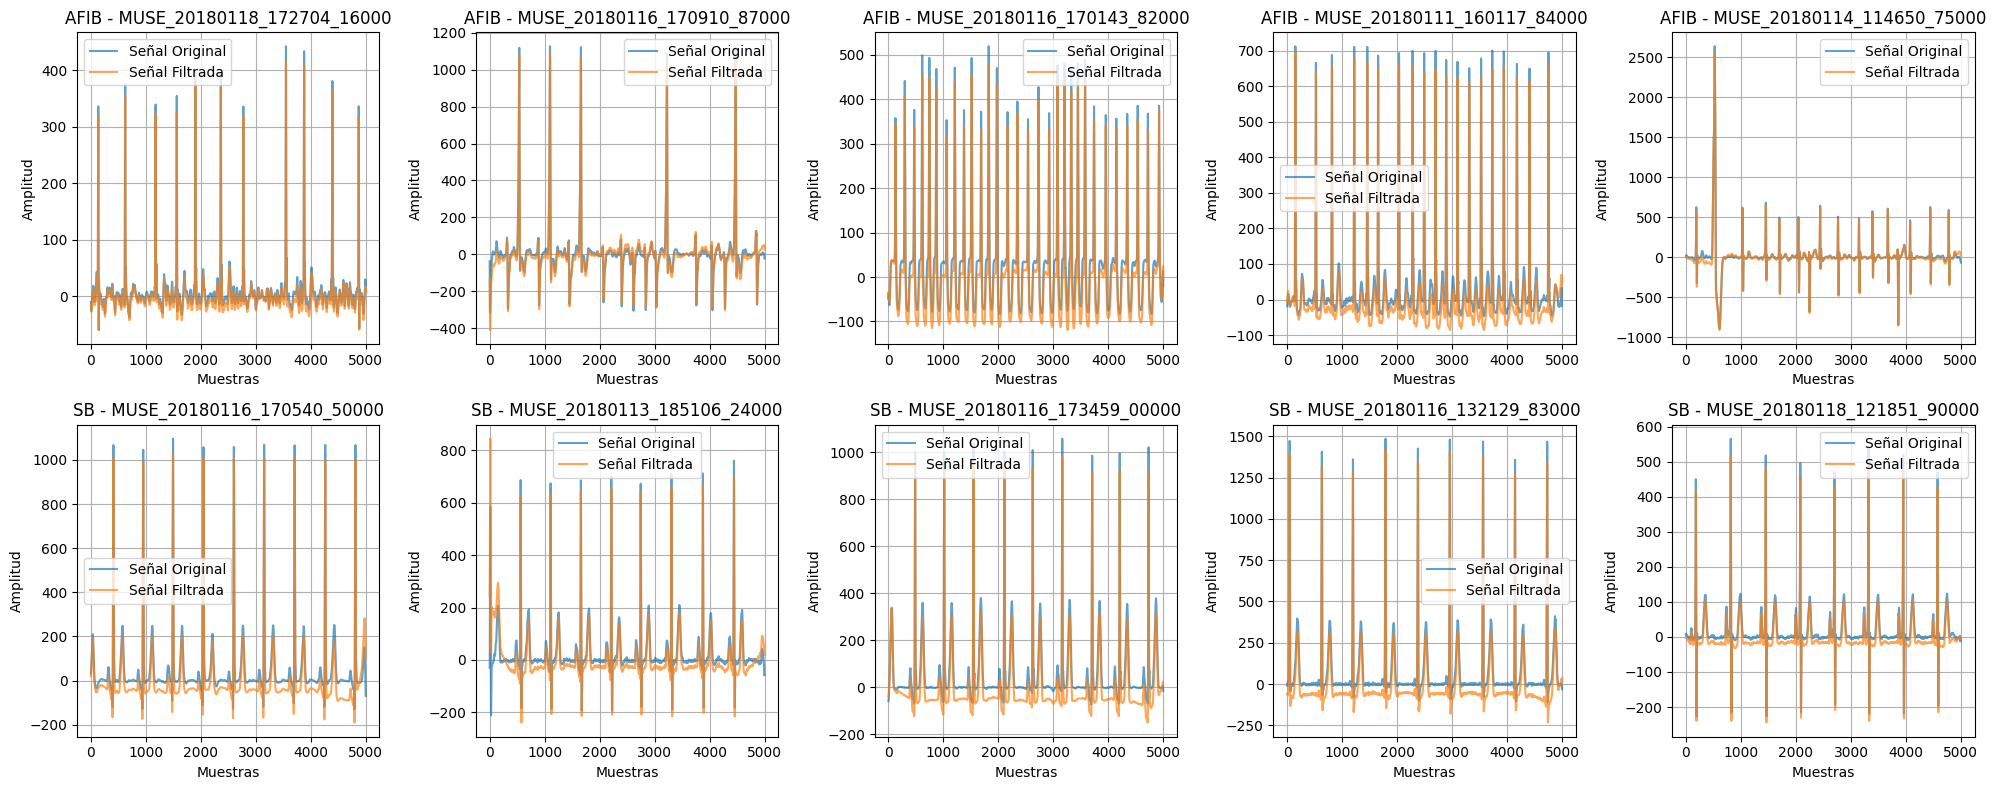

In [204]:
# Función para el flujo de procesamiento con filtros IIR y FIR
def flujo3(señales, tipo_señal, ax, fs=500):
    for i, (nombre_señal, señal) in enumerate(señales.items()):
        # Aplicar filtro pasa-altas IIR a 0.5 Hz
        señal_filtrada_hp = filtro_pasa_altos(señal, corte=0.5, fs=fs)
        
        # Aplicar filtro pasa-bajos FIR a 50 Hz
        señal_filtrada_final = filtro_pasa_bajos(señal_filtrada_hp, corte=50, fs=fs, orden=40)
        
        # Graficar la señal original y filtrada en el subplot correspondiente
        ax[i].plot(señal, label='Señal Original', alpha=0.7)
        ax[i].plot(señal_filtrada_final, label='Señal Filtrada', alpha=0.7)
        ax[i].set_title(f"{tipo_señal} - {nombre_señal}")
        ax[i].set_xlabel("Muestras")
        ax[i].set_ylabel("Amplitud")
        ax[i].legend()
        ax[i].grid(True)

# Función optimizada para procesar y graficar señales de AFIB y SB en subplots
def procesar_todas_las_señales_completas(valores_AFIB, valores_SB, fs=500):
   
    señales_AFIB_seleccionadas = dict(list(valores_AFIB.items())[:5])
    señales_SB_seleccionadas = dict(list(valores_SB.items())[:5])
    
    # Crear figura y subplots organizados en una cuadrícula de 2x5
    fig, ax = plt.subplots(2, 5, figsize=(20, 8))
    ax = ax.flatten()  # Aplana el arreglo de subplots para un fácil acceso
    
    # Procesar y graficar las señales
    flujo3(señales_AFIB_seleccionadas, 'AFIB', ax[:5], fs)  # Primeras 5 subplots para AFIB
    flujo3(señales_SB_seleccionadas, 'SB', ax[5:], fs)      # Últimas 5 subplots para SB
    
    plt.tight_layout()
    plt.show()

# Llamada a la función para procesar y graficar las señales en subplots con flujo 3
procesar_todas_las_señales_completas(señales_AFIB_aleatorias, señales_SB_aleatorias, fs=500)




Describir los resultados obtenidos y decidir si el resto del procesamiento se hace con el flujo 1, el flujo 2 o el flujo 3 (20%)

## Descripción Visual de los resultados.

Los resultados del análisis muestran que el Flujo 1 ofrece la mejor combinación de eliminación de ruido y preservación de las características morfológicas del ECG. Al aplicar un filtro pasa-altas inicial seguido de un filtrado wavelet, se logra una eficaz eliminación de la deriva de línea base sin comprometer las componentes de alta frecuencia. El filtrado pasabajas final a 50 Hz suaviza cualquier artefacto residual, resultando en una señal limpia y de alta calidad. En contraste, el Flujo 2 presenta una mayor distorsión en la amplitud de los picos, mientras que el Flujo 3 muestra una menor efectividad en la eliminación de ruido, especialmente en las zonas entre complejos QRS. La señal filtrada del Flujo 1 mantiene de manera precisa la amplitud y forma de los complejos QRS, lo que indica una mejor preservación de la información fisiológica relevante.

## COMPARACIÓN RUIDO - DISTORCIÓN DE EXPECTRO

 Para seleccionar el mejor flujo realizamos una evaluacion para el procesamiento final de todas las señales, en esta evaluacion se realizo el calculo de SNR ( Signal-to-Noise Ratio (SNR))  o Relación Señal a Ruido en español, que  es una medida que compara el nivel de la señal deseada con respecto al nivel de ruido de fondo [7]. Es un indicador muy importante de la calidad de una señal. Ademas comparamos la distorcion espectral, la distorsión espectral es un fenómeno importante a considerar ya que puede ayudar a identificar la calidad de los datos y la precisión de los análisis.



In [228]:
# Función para calcular la relación señal-ruido (SNR)
def calcular_snr(señal_original, señal_filtrada):
    # Asegurarse de que ambas señales tengan la misma longitud
    min_len = min(len(señal_original), len(señal_filtrada))
    señal_original = señal_original[:min_len]
    señal_filtrada = señal_filtrada[:min_len]

    ruido = señal_original - señal_filtrada
    señal_power = np.sum(señal_filtrada ** 2)
    ruido_power = np.sum(ruido ** 2)
    snr = 10 * np.log10(señal_power / ruido_power)
    return snr

# Función para calcular la distorsión espectral
def calcular_distorsion_espectral(señal_original, señal_filtrada, fs, nperseg=1024):
    # Asegurarse de que ambas señales tengan la misma longitud
    min_len = min(len(señal_original), len(señal_filtrada))
    señal_original = señal_original[:min_len]
    señal_filtrada = señal_filtrada[:min_len]

    freqs_original, psd_original = welch(señal_original, fs=fs, nperseg=nperseg)
    freqs_filtrada, psd_filtrada = welch(señal_filtrada, fs=fs, nperseg=nperseg)
    distorsion = np.mean(np.abs(psd_original - psd_filtrada))
    return distorsion


Para cada Flujo se realiza la evaluacion que nos ayudara a determinar cual flujo es mejor.

In [235]:
# Función para evaluar el flujo 1 y calcular métricas de calidad
def evaluar_flujo1(señales, fs=500, nperseg=1024):
    resultados = {}
    for nombre_señal, señal in señales.items():

        # Filtro PASA-Alta
        señal_filtrada_hp = filtro_pasa_altos(señal, corte=0.5, fs=fs)

        # Filtro wavelet modificado (SYMLET)
        señal_filtrada_wavelet = SYMLET_wavelet(señal_filtrada_hp, wavelet='sym8', nivel=8)
        
        # Filtro pasa-bajos 50 Hz
        señal_filtrada_final = filtro_pasa_bajos(señal_filtrada_wavelet, corte=50, fs=fs, orden=40)
        
        # Calcular métricas de evaluación
        snr = calcular_snr(señal, señal_filtrada_final)
        distorsion_espectral = calcular_distorsion_espectral(señal, señal_filtrada_final, fs, nperseg)
        
        # Guardar resultados para cada señal
        resultados[nombre_señal] = {
            "SNR": snr,
            "Distorsión Espectral": distorsion_espectral
        }

    return resultados

# Ejemplo de cómo usar la función de evaluación en las señales aleatorias de AFIB y SB
resultados_flujo1_AFIB = evaluar_flujo1(señales_AFIB_aleatorias, fs=500)
resultados_flujo1_SB = evaluar_flujo1(señales_SB_aleatorias, fs=500)

# Función para imprimir los resultados
def imprimir_resultados(resultados, tipo_señal):
    print(f"Resultados de evaluación para el flujo 1 ({tipo_señal}):")
    for nombre_señal, metricas in resultados.items():
        print(f"{nombre_señal} - SNR: {metricas['SNR']:.2f} dB, Distorsión Espectral: {metricas['Distorsión Espectral']:.4f}")

# Mostrar resultados para AFIB y SB
imprimir_resultados(resultados_flujo1_AFIB, "AFIB")
imprimir_resultados(resultados_flujo1_SB, "SB")


Resultados de evaluación para el flujo 1 (AFIB):
MUSE_20180118_172704_16000 - SNR: 3.31 dB, Distorsión Espectral: 2.8774
MUSE_20180116_170910_87000 - SNR: 3.82 dB, Distorsión Espectral: 28.2493
MUSE_20180116_170143_82000 - SNR: -6.13 dB, Distorsión Espectral: 39.1343
MUSE_20180111_160117_84000 - SNR: 0.70 dB, Distorsión Espectral: 26.8937
MUSE_20180114_114650_75000 - SNR: 14.43 dB, Distorsión Espectral: 16.5528
Resultados de evaluación para el flujo 1 (SB):
MUSE_20180116_170540_50000 - SNR: 4.35 dB, Distorsión Espectral: 27.4216
MUSE_20180113_185106_24000 - SNR: 3.60 dB, Distorsión Espectral: 9.9954
MUSE_20180116_173459_00000 - SNR: -0.73 dB, Distorsión Espectral: 45.9729
MUSE_20180116_132129_83000 - SNR: 5.75 dB, Distorsión Espectral: 38.5812
MUSE_20180118_121851_90000 - SNR: 7.13 dB, Distorsión Espectral: 2.6291


In [231]:
# Función para evaluar el flujo 2 y calcular métricas de calidad
def evaluar_flujo2(señales, fs=500, nperseg=1024):
    resultados = {}
    for nombre_señal, señal in señales.items():
        # Aplicar detrend (eliminar la tendencia lineal)
        señal_detrendida = detrend_signal(señal)
        
        # Filtro wavelet modificado (SYMLET)
        señal_filtrada_wavelet = SYMLET_wavelet(señal_detrendida, wavelet='sym8', nivel=8)
        
        # Filtro pasa-bajos 50 Hz
        señal_filtrada_final = filtro_pasa_bajos(señal_filtrada_wavelet, corte=50, fs=fs, orden=40)
        
        # Calcular métricas de evaluación
        snr = calcular_snr(señal, señal_filtrada_final)
        distorsion_espectral = calcular_distorsion_espectral(señal, señal_filtrada_final, fs, nperseg)
        
        # Guardar resultados para cada señal
        resultados[nombre_señal] = {
            "SNR": snr,
            "Distorsión Espectral": distorsion_espectral
        }

    return resultados

# Ejemplo de cómo usar la función de evaluación en las señales aleatorias de AFIB y SB
resultados_flujo2_AFIB = evaluar_flujo2(señales_AFIB_aleatorias, fs=500)
resultados_flujo2_SB = evaluar_flujo2(señales_SB_aleatorias, fs=500)

# Función para imprimir los resultados
def imprimir_resultados(resultados, tipo_señal):
    print(f"Resultados de evaluación para el flujo 2 ({tipo_señal}):")
    for nombre_señal, metricas in resultados.items():
        print(f"{nombre_señal} - SNR: {metricas['SNR']:.2f} dB, Distorsión Espectral: {metricas['Distorsión Espectral']:.4f}")

# Mostrar resultados para AFIB y SB
imprimir_resultados(resultados_flujo2_AFIB, "AFIB")
imprimir_resultados(resultados_flujo2_SB, "SB")

Resultados de evaluación para el flujo 2 (AFIB):
MUSE_20180118_172704_16000 - SNR: 3.39 dB, Distorsión Espectral: 2.8336
MUSE_20180116_170910_87000 - SNR: 4.41 dB, Distorsión Espectral: 27.0393
MUSE_20180116_170143_82000 - SNR: -6.00 dB, Distorsión Espectral: 39.0161
MUSE_20180111_160117_84000 - SNR: 0.88 dB, Distorsión Espectral: 26.7853
MUSE_20180114_114650_75000 - SNR: 15.50 dB, Distorsión Espectral: 10.5543
Resultados de evaluación para el flujo 2 (SB):
MUSE_20180116_170540_50000 - SNR: 4.49 dB, Distorsión Espectral: 26.8994
MUSE_20180113_185106_24000 - SNR: 4.18 dB, Distorsión Espectral: 9.6147
MUSE_20180116_173459_00000 - SNR: -0.77 dB, Distorsión Espectral: 45.0257
MUSE_20180116_132129_83000 - SNR: 5.76 dB, Distorsión Espectral: 36.5998
MUSE_20180118_121851_90000 - SNR: 7.27 dB, Distorsión Espectral: 2.4594


Haciendo un analisis de los valores del SNR y la distorsión espectral vemos que mantiene un rango de valores muy similares siendo incluso algunos valores de la SNR mayroes para el flujo 2 , sin embargo por las caracteristicas visuales superiores que ofrece el flujo 1 usaremos este para procesar las senales de la base de datos.  

Con el flujo seleccionado procesar las señales de la base de datos ECGData.zip derivación II. En este punto deberíamos estar en el mismo punto donde partimos en el proyecto 2, con señales filtradas.

In [ ]:
valores_AFIB, valores_SB = leer_archivos_ecg(nombres_AFIB, nombres_SB, ruta_carpeta_csv)

In [ ]:
def flujo1_2(señal):
    señales_procesadas = {}
    for nombre, datos in señal.items():
        # Filtro pasa-altas
        señal_filtrada_hp = filtro_pasa_altos(datos, )
        # Umbralización wavelet
        señal_filtrada_wavelet = SYMLET_wavelet(señal_filtrada_hp, wavelet='sym8', nivel=8)        
        # Filtro pasa-bajas
        señal_filtrada_final = filtro_pasa_bajas(señal_filtrada_wavelet)
        señales_procesadas[nombre] = señal_filtrada_final

    return señales_procesadas

# Aplicar el flujo y graficar las señales
valores_AFIB_filtrado = flujo1_2(valores_AFIB)
valores_SB_filtrado = flujo1_2(valores_SB)

A las señales filtradas con el flujo 1 seleccionado se le aplica  el procesamiento de  detrend , compresion (normalización) y de nuevo detrend como en el proyecto 2. , para evitar errores en el resultado.  Teniendo encuenta que para el proyecto anterior nos recoemndaron usar el detrend de la libreria Scipy. 

In [256]:
def compress(señal):
  señal = np.array(señal)
  señal1 = señal- np.mean(señal)
  x_min = np.min(señal1 )
  x_max = np.max(señal1 )
  señal_n= (señal1  - x_min) / (x_max - x_min)

  return señal_n

In [ ]:
def frecuencia_max_potencia_welch(signal_data, fs):
    freqs, potencia = signal.welch(signal_data, fs, nperseg=1024)
    idx_max = np.argmax(potencia)
    freq_max = freqs[idx_max]
    pot_max = potencia[idx_max]

    return freq_max, pot_max, freqs, potencia

In [269]:
# Función de flujo para el procesamiento de detrend, compresión y detrend
def procesamiento_detrend_compress(señales):
    señales_procesadas = {}
    for nombre, datos in señales.items():
        # Primer detrend
        señal_detrended = detrend(datos)
        
        # Compresión
        señal_comprimida = compress(señal_detrended)
        
        # Segundo detrend
        señal_final = detrend(señal_comprimida)
        
        señales_procesadas[nombre] = señal_final

    return señales_procesadas

# Aplicar el procesamiento
valores_AFIB_procesado = procesamiento_detrend_compress(valores_AFIB_filtrado)
valores_SB_procesado = procesamiento_detrend_compress(valores_SB_filtrado)
Valores_AFID_Originales_procesados=procesamiento_detrend_compress(valores_AFIB)
Valores_SB_Originales_procesados=procesamiento_detrend_compress(valores_SB)

La elección de los filtros IIR y FIR en diferentes etapas del procesamiento de la señal ECG se fundamenta en las ventajas específicas de cada tipo de filtro. Para el filtro pasa-altas inicial, se seleccionó un IIR debido a su alta eficiencia y capacidad de lograr una transición nítida entre la banda de paso y la banda de rechazo con un menor orden, reduciendo así la carga computacional. Además, su topología elíptica permite ajustar parámetros como el rizado en la banda de paso y la atenuación mínima, lo cual mejora la selectividad y facilita la eliminación de componentes de baja frecuencia sin perder detalles importantes. Al final del procesamiento, se utiliza un filtro FIR pasa-bajas por su estabilidad inherente y su respuesta de fase lineal, lo que garantiza que no haya distorsión en los picos y ondas de la señal ECG. Esta combinación permite un filtrado progresivo que conserva la integridad de la señal, optimizando la calidad de filtrado y la eficiencia del sistema.


Se realizo el procesamiento , tanto para las señales originales y filtradas para luego hacer la comparacion estadistica entre ellas.

## 5. Para cada señal extraer la frecuencia que contiene la máxima potencia usando Welch (15%)

In [297]:
def espectro_potencia_welch(signal, fs, window, nperseg, noverlap):
    f, power = welch(signal, fs, window=window, nperseg=nperseg, noverlap=noverlap)
    idx_max = np.argmax(power)
    # Se obtiene la frecuencia de máxima potencia
    frecuencia_maxima_potencia = f[idx_max]
    return f, power , frecuencia_maxima_potencia

Frecuencia de máxima potencia para el archivo SB: 5.37109375
Frecuencia de máxima potencia para el archivo AFIB: 15.13671875


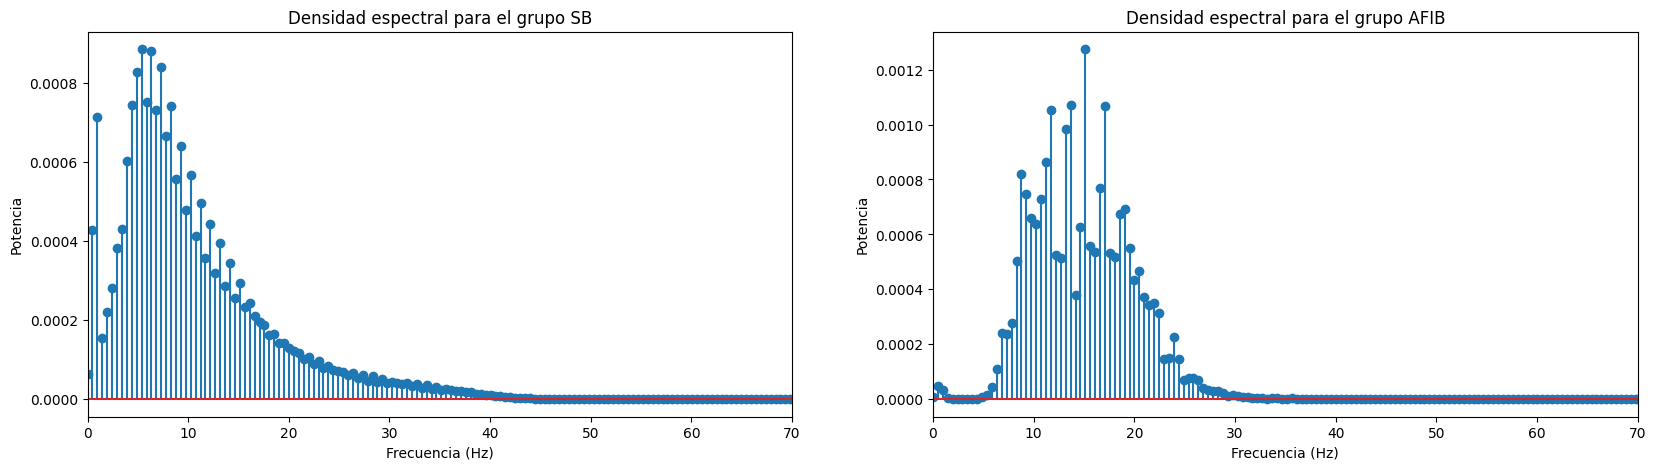

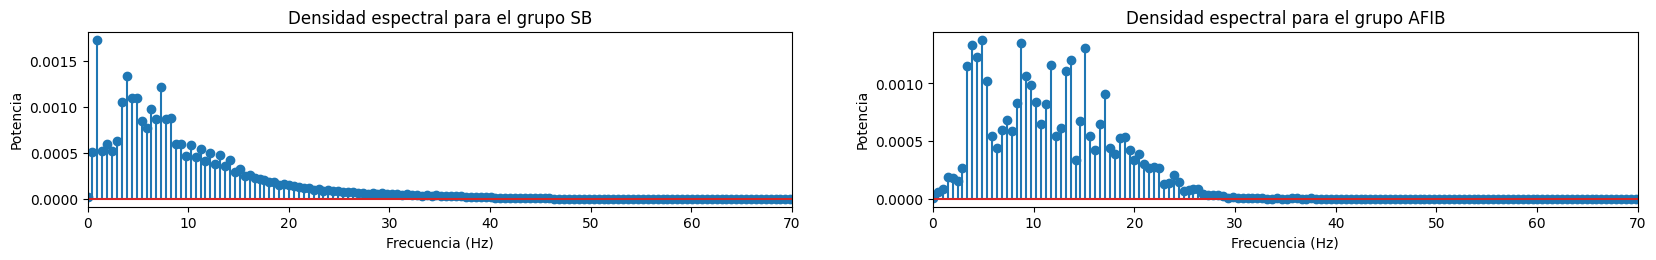

In [ ]:

data_AFIB = valores_AFIB_procesado["MUSE_20180111_155154_74000"]
data_SB = valores_SB_procesado["MUSE_20180111_155758_17000"]
data_AFIB_original = Valores_AFID_Originales_procesados["MUSE_20180111_155154_74000"]
data_SB_original = Valores_SB_Originales_procesados["MUSE_20180111_155758_17000"]

fs=500
nperseg = 1024 # Ancho de la ventana, nperseg no debe ser mayor que la longitud de la señal
noverlap = int(nperseg / 2)  # Solapamiento de las ventanas del 50%
ventana = np.hamming(nperseg)  # Ventana Hamming
# Calcular el periodograma de Welch
f_AFIB, power_AFIB, frec_max_AFIB = espectro_potencia_welch(data_AFIB, fs, window=ventana, nperseg=nperseg, noverlap=noverlap)
f_SB, power_SB, frec_max_SB = espectro_potencia_welch(data_SB, fs, window=ventana, nperseg=nperseg, noverlap=noverlap)


f_AFIB_o, power_AFIB_o, frec_max_AFIB_original = espectro_potencia_welch(data_AFIB_original, fs, window=ventana, nperseg=nperseg, noverlap=noverlap)
f_SB_o, power_SB_o, frec_max_SB_original = espectro_potencia_welch(data_SB_original, fs, window=ventana, nperseg=nperseg, noverlap=noverlap)

# Se grafica frecuencia vs potencia
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.stem(f_SB, power_SB)
plt.ylabel('Potencia')
plt.xlabel('Frecuencia (Hz)')
plt.xlim(0, 70)
plt.title("Densidad espectral para el grupo SB")

plt.subplot(1,2,2)
plt.stem(f_AFIB, power_AFIB)
plt.ylabel('Potencia')
plt.xlabel('Frecuencia (Hz)')
plt.xlim(0, 70)
plt.title("Densidad espectral para el grupo AFIB")

plt.figure(figsize=(20,5))
plt.subplot(2,2,1)
plt.stem(f_SB_o, power_SB_o)
plt.ylabel('Potencia')
plt.xlabel('Frecuencia (Hz)')
plt.xlim(0, 70)
plt.title("Densidad espectral para el grupo SB")

plt.subplot(2,2,2)
plt.stem(f_AFIB_o, power_AFIB_o)
plt.ylabel('Potencia')
plt.xlabel('Frecuencia (Hz)')
plt.xlim(0, 70)
plt.title("Densidad espectral para el grupo AFIB")


print(f"Frecuencia de máxima potencia para el archivo SB: {frec_max_SB}")
print(f"Frecuencia de máxima potencia para el archivo AFIB: {frec_max_AFIB}")

Analizando las imágenes de densidad espectral de potencia para los grupos SB y AFIB, se pueden observar varios aspectos importantes:
#### Comparación de Amplitudes:
- En las señales sin filtrar (arriba):
    SB: Máxima potencia ~0.0008
    AFIB: Máxima potencia ~0.0012
- En las señales filtradas (abajo):
    SB: Máxima potencia ~0.0015
    AFIB: Máxima potencia ~0.0010-0.0012
- Distribución Frecuencial:
    Ambos grupos muestran la mayor concentración de energía entre 0-30 Hz
    AFIB muestra una distribución más uniforme en el rango 5-25 Hz
    SB muestra picos más pronunciados en frecuencias bajas (0-10 Hz)

In [326]:
fs=500
nperseg = 1024 # Ancho de la ventana, nperseg no debe ser mayor que la longitud de la señal
noverlap = int(nperseg / 2)  # Solapamiento de las ventanas del 50%
ventana = np.hamming(nperseg)  # Ventana Hamming

def espectro_potencia_welch(signal, fs, window=ventana, nperseg=1024, noverlap=int(nperseg / 2)):
    f, power = welch(signal, fs, window=window, nperseg=nperseg, noverlap=noverlap)
    idx_max = np.argmax(power)
    # Se obtiene la frecuencia de máxima potencia
    frecuencia_maxima_potencia = f[idx_max]
    return f, power , frecuencia_maxima_potencia

# Función para extraer las frecuencias máximas de potencia de cada señal y almacenarlas en un DataFrame
def extraer_frecuencia_maxima_potencia(señales, fs=500):
    frecuencias_maximas = []

    # Recorrer las señales
    for nombre_señal, señal in señales.items():
        # Extraer la frecuencia máxima de potencia
        _,_,f_max_Potencia =  espectro_potencia_welch(señal, fs)
        
        # Agregar el nombre de la señal y la frecuencia máxima al listado
        frecuencias_maximas.append({'Nombre': nombre_señal, 'FMP': f_max_Potencia})
    
    # Crear un DataFrame con las frecuencias máximas
    df_frecuencias = pd.DataFrame(frecuencias_maximas)
    
    return df_frecuencias



df_AFIB_filtrado = extraer_frecuencia_maxima_potencia(valores_AFIB_procesado)
df_SB_filtrado = extraer_frecuencia_maxima_potencia(valores_SB_procesado)
df_AFIB_original = extraer_frecuencia_maxima_potencia(Valores_AFID_Originales_procesados)
df_SB_original = extraer_frecuencia_maxima_potencia(Valores_SB_Originales_procesados)


# Mostrar los DataFrames con las frecuencias máximas de potencia
print("Frecuencias máximas de potencia para AFIB Original:")
print(df_AFIB_original)

print("Frecuencias máximas de potencia para AFIB Filtrada:")
print(df_AFIB_filtrado)

print("\nFrecuencias máximas de potencia para SB Original:")
print(df_SB_original)

print("\nFrecuencias máximas de potencia para SB Filtrada:")
print(df_SB_filtrado)


Frecuencias máximas de potencia para AFIB Original:
                          Nombre        FMP
0     MUSE_20180113_171327_27000  13.183594
1     MUSE_20180114_075026_69000   4.394531
2     MUSE_20180113_133901_16000   3.906250
3     MUSE_20180116_123940_90000   1.464844
4     MUSE_20180114_075003_61000   3.906250
...                          ...        ...
1775  MUSE_20180116_120939_86000   3.906250
1776  MUSE_20180114_134126_54000   2.929688
1777  MUSE_20180115_131040_20000   3.417969
1778  MUSE_20180116_170450_55000   2.929688
1779  MUSE_20180115_131524_93000   1.464844

[1780 rows x 2 columns]
Frecuencias máximas de potencia para AFIB Filtrada:
                          Nombre        FMP
0     MUSE_20180113_171327_27000  13.183594
1     MUSE_20180114_075026_69000  11.718750
2     MUSE_20180113_133901_16000   6.835938
3     MUSE_20180116_123940_90000  11.230469
4     MUSE_20180114_075003_61000   5.859375
...                          ...        ...
1775  MUSE_20180116_120939_86000  1

## 6. Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 al 5 y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP):

se creo una rutina que aplica sobre todos los archivos por separdo para cada patologia

### DATAFRAME PROYECTO 2

In [ ]:
dataoriginal= []

for archivo, fmp in valores_AFIB.items():
    # Obtener el valor correspondiente de fMP para cada archivo
    fmp_value = df_AFIB_original.loc[df_AFIB_original['Nombre'] == archivo, 'FMP'].values[0]

    # Añadir la información al diccionario
    dataoriginal.append({'Nombre': archivo, 'Condición': 'AFIB', 'FMP': fmp_value})

# Convertir la lista de diccionarios en un DataFrame
df_resultados_AFIB_original = pd.DataFrame(dataoriginal)

# Mostrar el DataFrame
df_resultados_AFIB_original

,Nombre,Condición,FMP
0,MUSE_20180113_171327_27000,AFIB,13.183594
1,MUSE_20180114_075026_69000,AFIB,4.394531
2,MUSE_20180113_133901_16000,AFIB,3.906250
3,MUSE_20180116_123940_90000,AFIB,1.464844
4,MUSE_20180114_075003_61000,AFIB,3.906250
...,...,...,...
1775,MUSE_20180116_120939_86000,AFIB,3.906250
1776,MUSE_20180114_134126_54000,AFIB,2.929688
1777,MUSE_20180115_131040_20000,AFIB,3.417969
1778,MUSE_20180116_170450_55000,AFIB,2.929688


In [343]:
dataoriginal2= []

for archivo, fmp in valores_SB.items():
    # Obtener el valor correspondiente de fMP para cada archivo
    fmp_value = df_SB_original.loc[df_SB_original['Nombre'] == archivo, 'FMP'].values[0]

    # Añadir la información al diccionario
    dataoriginal2.append({'Nombre': archivo, 'Condición': 'AFIB', 'FMP': fmp_value})

# Convertir la lista de diccionarios en un DataFrame
df_resultados_SB_original = pd.DataFrame(dataoriginal2)

# Mostrar el DataFrame
df_resultados_SB_original

,Nombre,Condición,FMP
0,MUSE_20180112_073319_29000,AFIB,3.417969
1,MUSE_20180113_121940_44000,AFIB,3.417969
2,MUSE_20180112_120347_79000,AFIB,3.906250
3,MUSE_20180114_075128_92000,AFIB,0.976562
4,MUSE_20180118_174026_42000,AFIB,2.929688
...,...,...,...
3884,MUSE_20180114_070348_17000,AFIB,2.929688
3885,MUSE_20180114_134724_10000,AFIB,2.929688
3886,MUSE_20180113_122544_20000,AFIB,0.976562
3887,MUSE_20180114_074720_85000,AFIB,11.230469


### DATAFRAME PROYECTO 3 

In [344]:
data = []

for archivo, fmp in valores_AFIB.items():
    # Obtener el valor correspondiente de fMP para cada archivo
    fmp_value = df_AFIB_filtrado.loc[df_AFIB_filtrado['Nombre'] == archivo, 'FMP'].values[0]

    # Añadir la información al diccionario
    data.append({'Nombre': archivo, 'Condición': 'AFIB', 'FMP': fmp_value})

# Convertir la lista de diccionarios en un DataFrame
df_resultados_AFIB = pd.DataFrame(data)

# Mostrar el DataFrame
df_resultados_AFIB

,Nombre,Condición,FMP
0,MUSE_20180113_171327_27000,AFIB,13.183594
1,MUSE_20180114_075026_69000,AFIB,11.718750
2,MUSE_20180113_133901_16000,AFIB,6.835938
3,MUSE_20180116_123940_90000,AFIB,11.230469
4,MUSE_20180114_075003_61000,AFIB,5.859375
...,...,...,...
1775,MUSE_20180116_120939_86000,AFIB,13.183594
1776,MUSE_20180114_134126_54000,AFIB,6.835938
1777,MUSE_20180115_131040_20000,AFIB,5.859375
1778,MUSE_20180116_170450_55000,AFIB,6.347656


In [335]:
data2 = []

for archivo, fmp in valores_SB.items():
    # Obtener el valor correspondiente de fMP para cada archivo
    fmp_value = df_SB_filtrado.loc[df_SB_filtrado['Nombre'] == archivo, 'FMP'].values[0]

    # Añadir la información al diccionario
    data2.append({'Nombre': archivo, 'Condición': 'SB', 'FMP': fmp_value})

# Convertir la lista de diccionarios en un DataFrame
df_resultados_SB = pd.DataFrame(data2)

# Mostrar el DataFrame
df_resultados_SB


,Nombre,Condición,FMP
0,MUSE_20180112_073319_29000,SB,6.835938
1,MUSE_20180113_121940_44000,SB,3.417969
2,MUSE_20180112_120347_79000,SB,3.906250
3,MUSE_20180114_075128_92000,SB,0.976562
4,MUSE_20180118_174026_42000,SB,14.648438
...,...,...,...
3884,MUSE_20180114_070348_17000,SB,8.789062
3885,MUSE_20180114_134724_10000,SB,2.929688
3886,MUSE_20180113_122544_20000,SB,0.976562
3887,MUSE_20180114_074720_85000,SB,11.230469


## 7.Comparar los resultados de fMP del proyecto 3 con los del proyecto 2 usando estadística descriptiva: gráficos y pruebas de hipótesis (15%) Discuta si hay más diferencias entre los tipos de señales con el flujo de procesamiento propuesto respecto al que se trabajó en el proyecto 2. 

In [351]:
# Valores de FMP de cada DataFrame Proyecto 2
FMP_SB_original_values = df_resultados_SB_original['FMP'].values
FMP_AFIB_original_values = df_resultados_AFIB_original['FMP'].values
# Valores de FMP de cada DataFrame Proyecto 3
FMP_SB_values = df_resultados_SB['FMP'].values
FMP_AFIB_values = df_resultados_AFIB['FMP'].values


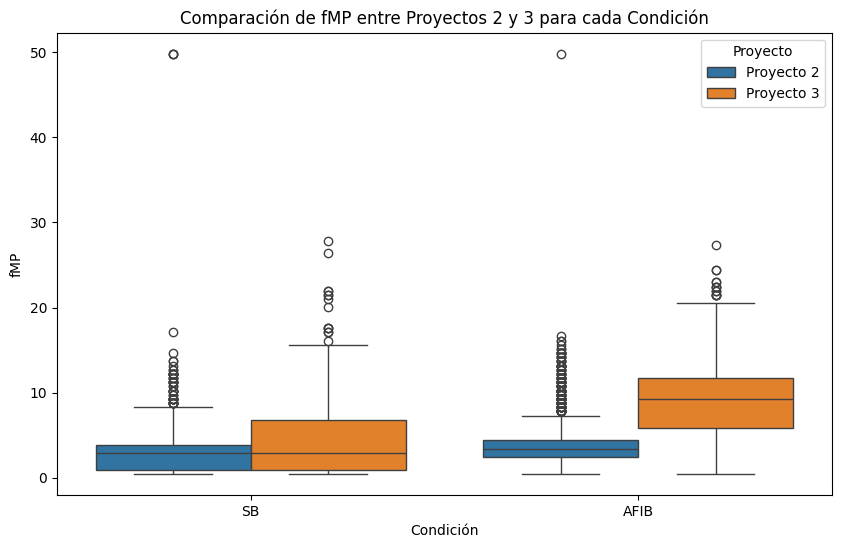

In [354]:
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

# Cargar y concatenar los datos de fMP de los dos proyectos en un solo DataFrame
#PROYECTO 2
df_P2 = pd.DataFrame({
    'Condición': ['SB'] * len(FMP_SB_original_values) + ['AFIB'] * len(FMP_AFIB_original_values),
    'fMP': list(FMP_SB_original_values) + list(FMP_AFIB_original_values),
    'Proyecto': 'Proyecto 2'
})
#PROYECTO 3 
df_P3 = pd.DataFrame({
    'Condición': ['SB'] * len(FMP_SB_values) + ['AFIB'] * len(FMP_AFIB_values),
    'fMP': list(FMP_SB_values) + list(FMP_AFIB_values),
    'Proyecto': 'Proyecto 3'
})

# Combinar los DataFrames
df_total = pd.concat([df_P2, df_P3], ignore_index=True)

# Gráfico de caja para comparar la distribución de fMP
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_total, x='Condición', y='fMP', hue='Proyecto')
plt.title("Comparación de fMP entre Proyectos 2 y 3 para cada Condición")
plt.show()




#### Planteamiento de Hipótesis para Normalidad y Homocedasticidad

### Normalidad:

Hipótesis Nula (H₀): Los datos de fMP siguen una distribución normal.
Hipótesis Alternativa (H₁): Los datos de fMP no siguen una distribución normal.

### Homocedasticidad:

Hipótesis Nula (H₀): No hay diferencias significativas entre las distribuciones de fMP de los proyectos 2 y 3 para un estado específico (homocedasticidad).
Hipótesis Alternativa (H₁): Las distribuciones de fMP para el estado específico difieren entre los proyectos 2 y 3 (heterocedasticidad).

In [370]:
from scipy import stats

# Cálculo de estadísticas descriptivas
print(df_total.groupby(['Proyecto', 'Condición'])['fMP'].describe())

# Pruebas de hipótesis (Ejemplo: SB y AFIB en ambos proyectos)
# Comparar fMP entre Proyectos 2 y 3 para SB
stat, p_value_SB = stats.ttest_ind(FMP_SB_original_values, FMP_SB_values, alternative='two-sided')
print("Prueba t (SB, Proyecto 2 vs. Proyecto 3):", p_value_SB)

# Prueba de normalidad: Kolmogorov-Smirnov (KS)
# Para Proyecto 3, grupo con SB
stat_normalidad_fMP_SB, p_valor_normalidad_fMP_SB = stats.kstest(FMP_SB_values, 'norm')
print(f'P-valor para fMP para el grupo con SB en Proyecto 3 es: {p_valor_normalidad_fMP_SB:.4f}')
alfa = 0.05  # Nivel de significancia
if p_valor_normalidad_fMP_SB > alfa:
    print('No se rechaza la hipótesis nula. Los datos de fMP del grupo con SB en Proyecto 3 siguen una distribución normal.')
else:
    print('Se rechaza la hipótesis nula. Los datos de fMP del grupo con SB en Proyecto 3 no siguen una distribución normal.')

# Para Proyecto 3, grupo con AFIB
stat_normalidad_fMP_AFIB, p_valor_normalidad_fMP_AFIB = stats.kstest(FMP_AFIB_values, 'norm')
print(f'P-valor para fMP para el grupo con AFIB en Proyecto 3 es: {p_valor_normalidad_fMP_AFIB:.4f}')
if p_valor_normalidad_fMP_AFIB > alfa:
    print('No se rechaza la hipótesis nula. Los datos de fMP del grupo con AFIB en Proyecto 3 siguen una distribución normal.')
else:
    print('Se rechaza la hipótesis nula. Los datos de fMP del grupo con AFIB en Proyecto 3 no siguen una distribución normal.')

# Para Proyecto 2, grupo con SB
stat_normalidad_fMP_SB_P2, p_valor_normalidad_fMP_SB_P2 = stats.kstest(FMP_SB_original_values, 'norm')
print(f'P-valor para fMP para el grupo con SB en Proyecto 2 es: {p_valor_normalidad_fMP_SB_P2:.4f}')
if p_valor_normalidad_fMP_SB_P2 > alfa:
    print('No se rechaza la hipótesis nula. Los datos de fMP del grupo con SB en Proyecto 2 siguen una distribución normal.')
else:
    print('Se rechaza la hipótesis nula. Los datos de fMP del grupo con SB en Proyecto 2 no siguen una distribución normal.')

# Para Proyecto 2, grupo con AFIB
stat_normalidad_fMP_AFIB_P2, p_valor_normalidad_fMP_AFIB_P2 = stats.kstest(FMP_AFIB_original_values, 'norm')
print(f'P-valor para fMP para el grupo con AFIB en Proyecto 2 es: {p_valor_normalidad_fMP_AFIB_P2:.4f}')
if p_valor_normalidad_fMP_AFIB_P2 > alfa:
    print('No se rechaza la hipótesis nula. Los datos de fMP del grupo con AFIB en Proyecto 2 siguen una distribución normal.')
else:
    print('Se rechaza la hipótesis nula. Los datos de fMP del grupo con AFIB en Proyecto 2 no siguen una distribución normal.')

# Supuesto de Homocedasticidad
# Prueba de Levene para comprobar homocedasticidad (igualdad de varianzas)
fMP_P3 = df_P3["fMP"]
fMP_P2 = df_P2["fMP"]
stat_homogeneidad_sFSB_fMP, p_valor_homogeniedad_sFSB_fMP = stats.levene(fMP_P3, fMP_P2, center='median')
print(f'P-valor para homocedasticidad: {p_valor_homogeniedad_sFSB_fMP:.4f}')
if p_valor_homogeniedad_sFSB_fMP > alfa:
    print('No se rechaza la hipótesis nula. Los datos de fMP para los dos proyectos proceden de distribuciones con la misma varianza.')
else:
    print('Se rechaza la hipótesis nula. Los datos de fMP para los dos proyectos no proceden de distribuciones con la misma varianza.')



                       count      mean       std       min       25%  \
Proyecto   Condición                                                   
Proyecto 2 AFIB       1780.0  3.934230  2.628128  0.488281  2.441406   
           SB         3889.0  3.095419  2.293452  0.488281  0.976562   
Proyecto 3 AFIB       1780.0  8.703750  4.641588  0.488281  5.859375   
           SB         3889.0  4.169789  3.702262  0.488281  0.976562   

                           50%        75%        max  
Proyecto   Condición                                  
Proyecto 2 AFIB       3.417969   4.394531  49.804688  
           SB         2.929688   3.906250  49.804688  
Proyecto 3 AFIB       9.277344  11.718750  27.343750  
           SB         2.929688   6.835938  27.832031  
Prueba t (SB, Proyecto 2 vs. Proyecto 3): 1.2377144803382625e-52
P-valor para fMP para el grupo con SB en Proyecto 3 es: 0.0000
Se rechaza la hipótesis nula. Los datos de fMP del grupo con SB en Proyecto 3 no siguen una distribución norm

In [368]:
stat, p_value_SB_MW = stats.mannwhitneyu(FMP_SB_original_values, FMP_SB_values, alternative='two-sided')
print("Prueba Mann-Whitney (SB, Proyecto 2 vs. Proyecto 3):", p_value_SB_MW)

stat, p_value_AFIB_MW = stats.mannwhitneyu(FMP_AFIB_original_values, FMP_AFIB_values, alternative='two-sided')
print("Prueba Mann-Whitney (AFIB, Proyecto 2 vs. Proyecto 3):", p_value_AFIB_MW)

Prueba Mann-Whitney (SB, Proyecto 2 vs. Proyecto 3): 9.611428832741234e-07
Prueba Mann-Whitney (AFIB, Proyecto 2 vs. Proyecto 3): 1.492773212596833e-207


# Discusión y Analisis de Resultados 
A partir de los análisis descriptivos, gráficos e inferenciales presentados, es posible realizar una discusión detallada sobre las diferencias y el analisis comparativo entre los Proyectos 2 y 3 en relación con el procesamiento de señales bajo las condiciones SB (sinusal basal) y AFIB (fibrilación auricular). 

#### CAJA DE BIGOTES 
Cada caja muestra los valores intercuartílicos (entre el primer y tercer cuartil), la mediana (línea dentro de la caja), y los bigotes que indican el rango de datos, excluyendo los valores atípicos (outliers), que se representan como puntos fuera de los bigotes.

En la Condición SB el Proyecto 2 muestra que la distribución de fMP es más estrecha, lo que indica una menor variabilidad y la mediana es más baja comparada con la del Proyecto 3 en este proyecto se observa una mayor dispersión de los datos con un rango intercuartílico más amplio. La mediana es superior a la del Proyecto 2, lo que sugiere que fMP tiende a ser más alto en este proyecto. Además, hay más valores atípicos dispersos por encima de 20.

EN la Condición AFIB el Proyecto 2 muestra que la distribución es similar a la de la condición SB, con una mediana baja y poca variabilidad. Los valores atípicos son menos pronunciados mientras que en el Proyecto 3 se destaca una mayor dispersión de los datos, con la caja más amplia que refleja una variabilidad considerablemente mayor. La mediana también es superior a la de Proyecto 2. Los valores atípicos se distribuyen más ampliamente, alcanzando valores de fMP notables.

Concluyendo que el flujo de procesamiento propuesto en el Proyecto 3 puede generar valores de fMP más elevados y variables. Con base a los gráficos de bigotes y el análisis previo, se observa que en el Proyecto 2 hay más outliers, lo que indica una mayor variabilidad en los datos de fMP. Esto podría deberse al procesamiento más sencillo, que no incorporó filtros avanzados. En cambio, el Proyecto 3, con un flujo de procesamiento más complejo, muestra menos dispersión y outliers, lo que sugiere que los filtros y el periodograma de Welch contribuyen a una mayor estabilidad de las señales. Las pruebas estadísticas, como la de normalidad y homocedasticidad, ayudan a confirmar si estas diferencias son significativas, ajustándose a las hipótesis de que los valores en el Proyecto 3 están mejor distribuidos. Se considera necesario realizar las demas pruebas para confirmar y profundizar más.

#### Descripción Estadística

En la condición SB, aunque la media y la dispersión son más altas en el Proyecto 3, la mediana se mantiene igual, lo que indica que los valores más elevados contribuyen significativamente al aumento de la media en este proyecto. En el Proyecto 2, los valores de fMP oscilan entre 0.49 y 49.80, mostrando que la mayoría de las observaciones se encuentran cerca de valores bajos, aunque existen algunos valores atípicos muy elevados. La distribución de fMP en el Proyecto 2 es estrecha y con menos dispersión, reflejando un flujo de procesamiento más conservador que detecta con menor frecuencia valores extremos.

Por el contrario, el flujo de procesamiento del Proyecto 3 muestra una mayor variabilidad en la condición SB, sugiriendo un modelo más sensible y adaptable a las fluctuaciones dentro de las señales basales. Esto implica que el Proyecto 2 sigue siendo valioso en contextos donde la estabilidad es más importante que la sensibilidad, mientras que el Proyecto 3 es preferible en entornos donde se requiere una alta capacidad de detección. En general, el Proyecto 2 mantiene los valores de fMP más cerca de la media, indicando menor dispersión y mayor estabilidad, mientras que el Proyecto 3 presenta una mayor dispersión, con máximos y percentiles más elevados. Esto sugiere que el Proyecto 3 es más adecuado para la detección de eventos raros o picos importantes, capturando mejor las fluctuaciones significativas. Sin embargo, esta mayor sensibilidad también plantea el desafío de controlar posibles falsos positivos, lo que requiere un equilibrio cuidadoso para asegurar precisión en las detecciones.

Por lo tanto desde una perspectiva fisiológica, el Proyecto 2 proporciona una evaluación más adecuada para SB donde la estabilidad y la precisión en la detección de valores extremos son menos críticas. Por el contrario, el Proyecto 3, con su mayor dispersión y capacidad para detectar variaciones significativas, se adapta mejor a la complejidad de la fibrilación auricular, donde una alta sensibilidad es crucial para monitorear las fluctuaciones y posibles eventos adversos. Sin embargo, esta misma sensibilidad exige un manejo cuidadoso para evitar un exceso de alarmas falsas, lo que puede ser problemático en un contexto clínico donde la precisión es esencial para la toma de decisiones.

SEGUNN LAS PRUEBAS DE NORMALIDAD Y HOMOSTECIDAD los datos de fMP para los grupos con SB y AFIB no siguen una distribución normal, ya que los p-valores de las pruebas de normalidad (Kolmogorov-Smirnov) son significativamente bajos (0.0000), lo que lleva a rechazar la hipótesis nula en todos los casos. Además, la prueba de homocedasticidad (Levene) muestra que los datos de fMP en ambos proyectos no presentan varianzas homogéneas, ya que el p-valor es también menor que el nivel de significancia, lo que indica heterocedasticidad entre los proyectos. En resumen, los datos no cumplen con los supuestos de normalidad ni de homocedasticidad, lo que debe ser considerado al seleccionar las pruebas estadísticas adecuadas.

#### Histograma 

Esto permite ver la frecuencia de cada rango de fMP y observar posibles diferencias en la dispersión o tendencias.

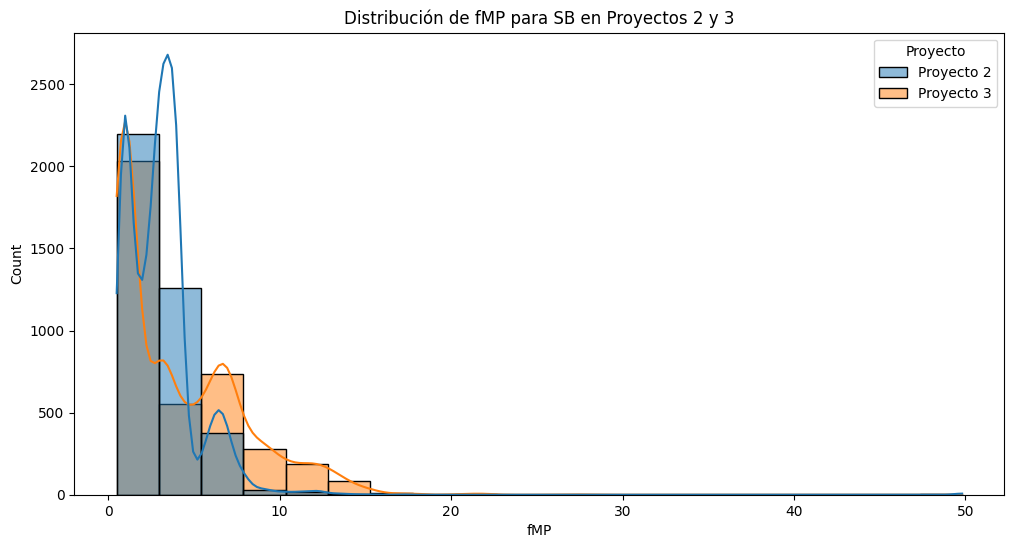

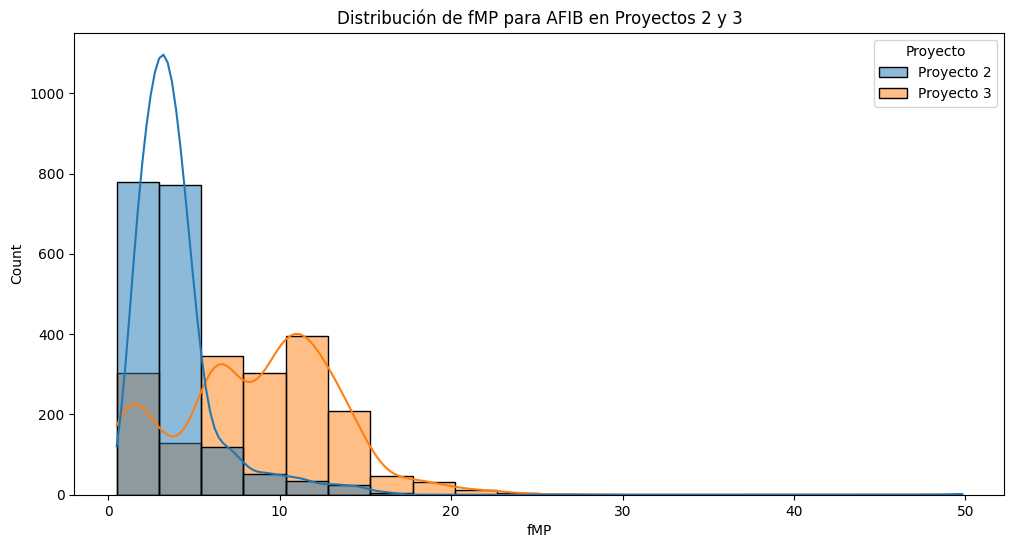

In [353]:
plt.figure(figsize=(12, 6))
sns.histplot(df_total[df_total['Condición'] == 'SB'], x='fMP', hue='Proyecto', kde=True, bins=20)
plt.title("Distribución de fMP para SB en Proyectos 2 y 3")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df_total[df_total['Condición'] == 'AFIB'], x='fMP', hue='Proyecto', kde=True, bins=20)
plt.title("Distribución de fMP para AFIB en Proyectos 2 y 3")
plt.show()


- En el histograma el análisis de las distribuciones de los proyectos revela diferencias significativas en su forma y dispersión. El Proyecto 2 (en azul) presenta una distribución hacia la derecha, con un pico pronunciado entre 2 y 3, lo que indica que la mayoría de los valores de fMP se concentran en un rango bajo, con una rápida disminución hacia valores más altos y una dispersión limitada. Esto sugiere que el flujo de procesamiento original favorecía la generación de valores bajos de fMP. En contraste, el Proyecto 3 (en naranja) exhibe una distribución más dispersa y menos simétrica, con un aplanamiento considerable y una cola extendida hacia valores altos, alcanzando hasta 50. Esta forma refleja una mayor variabilidad en los resultados y la presencia de valores elevados de fMP, especialmente entre 5 y 10, lo que implica que el flujo de procesamiento actualizado genera o detecta eventos más extremos. Además, en términos de densidad, el Proyecto 2 muestra una agrupación concentrada en el rango de 0 a 5, mientras que el Proyecto 3 presenta una distribución más extendida y una mayor frecuencia de valores altos, lo que destaca su mayor capacidad para manejar una variedad más amplia de respuestas. Por último, las colas de las distribuciones refuerzan estas diferencias: la cola del Proyecto 2 se atenúa rápidamente, indicando pocos valores elevados, mientras que la del Proyecto 3 se extiende considerablemente, señalando una mayor propensión a generar valores extremos de fMP.

#### CONCLUSIONES GENERALES 

- La aplicación conjunta de los métodos Robust LOESS y Non-Local Means en el procesamiento de señales ECG ofrece beneficios significativos en la precisión clínica de los datos. La capacidad de ambos métodos para eliminar ruidos específicos y preservar componentes esenciales permite obtener señales ECG más limpias
- Los filtros IIR (Respuesta Infinita al Impulso) fueron seleccionados para el filtrado pasa-altas al inicio debido a su alta eficiencia en términos de orden de filtro. Los filtros IIR pueden lograr una transición nítida entre la banda de paso y la banda de rechazo con un menor orden comparado con los filtros FIR
- Para el filtrado pasa-bajas al final del procesamiento, se optó por un filtro FIR (Respuesta Finita al Impulso) debido a su estabilidad inherente. Los filtros FIR son siempre estables y presentan una respuesta de fase lineal, lo cual es beneficioso para el filtrado de alta precisión en las últimas etapas del flujo.
- La implementación del Flujo 1 (filtro pasa-altas IIR + wavelet + pasabajas) mostró una mayor eficacia en el procesamiento de las señales, evidenciada tanto en el análisis visual como en las métricas de SNR, dónde vimos una mejor preservación de los complejos QRS, una eliminación efectiva del ruido y una distorsión pequeña de la morfología de las señales. 
- Al analizar la densidad espectral para dos señales, una para AFIB y otra para SB se evidencia que el filtrado ha mejorado la relación señal-ruido, evidenciado por el aumento en la amplitud de las componentes de interés en las bajas frecuencias, especialmente notable en el grupo SB.
- Las características espectrales distintivas entre AFIB y SB se mantienen después del filtrado, lo que sugiere que el proceso de filtrado preserva la información diagnóstica relevante mientras elimina el ruido no deseado
El proceso de filtrado ha modificado la distribución de energía en el espectro frecuencial, generalmente desplazando las frecuencias de máxima potencia hacia valores más altos.


REFERNCIA[1] https://www.nature.com/articles/s41598-020-59821-7
[2] https://www.statsmodels.org/dev/examples/notebooks/generated/lowess.html
[3] https://forum.image.sc/t/scikit-image-apply-parallel-slow-nlm-denoising/54308
[4] https://www.ijarse.com/images/fullpdf/1427379239_1167.pdf
[5] Pinto Moreno, E. (Año). Anexos. En [Título completo del documento principal si está disponible]. PFC.
[6] Burke, M., & Nasor, M. (2004). Wavelet based analysis and characterization of the ECG signal. Journal of Medical Engineering & Technology, 28(2), 47–55. doi:10.1080/0309190031000121532 